# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
from pylab import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# ignore warnings in the notebook
import warnings
warnings.filterwarnings('ignore')

# Part 2. Data Crawling

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd

driver = webdriver.Chrome()
driver.get("""https://www.sheypoor.com/%D8%AA%D9%87%D8%B1%D8%A7%D9%86/%D8%A7%D9%85%D9%84%D8%A7%DA%A9/%D8%AE%D8%B1%DB
%8C%D8%AF-%D9%81%D8%B1%D9%88%D8%B4-%D8%AE%D8%A7%D9%86%D9%87-%D8%A2%D9%BE%D8%A7%D8%B1%D8%AA%D9%85%D8%A7%D9%86""")
df = pd.DataFrame()
max_ad_for_each_district = 50
min_ad_for_each_district = 20
SCROLL_PAUSE_TIME = 2
retries_for_each_ad = 10

In [ ]:
i = 2
while True:
    try:   
        
        #District ID
        district_id = driver.find_element(By.XPATH, """//*[@id="popup-districts"]/div/ul/li[{number:}]""".format(number = i)).get_attribute('data-district-id') 
        #Click on chooseing district
        driver.find_element(By.XPATH, """//*[@id="search-fields"]/ul/li[1]/div/span""").click()
        #District Name
        district_name = driver.find_element(By.XPATH, """//*[@id="popup-districts"]/div/ul/li[{number:}]/label""".format(number = i)).text  
        # Uncheck The last District
        if i!= 2:
             driver.find_element(By.XPATH, """//*[@id="popup-districts"]/div/ul/li[2]/label""").click()
        #click on district
        driver.find_element(By.XPATH, """//*[@id="popup-districts"]/div/ul/li[{number:}]/label""".format(number = i)).click()  
        #click on OK
        driver.find_element(By.XPATH, """//*[@id="popup-districts"]/div/div[2]""").click() 
        # wait for page to load
        time.sleep(2)
        
        # Try to agahi haye bishtar
        try:
            driver.find_element(By.XPATH, """//*[@id="serp"]/section/button""").click()
        except:
            pass
        
        # Scroll to load more ads

        # find Links of ads
        ads = set()
        ads_get = set(driver.find_elements(By.XPATH, """//*[@id="serp-wrapper"]/div/article"""))
        for ad in ads_get:
            ads.update({ad.get_attribute('data-href')})
        

        # Get scroll height
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            # Scroll down to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            # Wait to load page
            time.sleep(SCROLL_PAUSE_TIME)

            # Calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")
            #load new ads
            ads_get = set(driver.find_elements(By.XPATH, """//*[@id="serp-wrapper"]/div/article"""))
            for ad in ads_get:
                ads.update({ad.get_attribute('data-href')})        
            if len(ads) >= max_ad_for_each_district or new_height == last_height:
                break                
            last_height = new_height
            




                
        print(f'district {district_name} with the total of  , {len(ads)} ads')
        
        # for each mahalle
        if len(ads) >= min_ad_for_each_district:
            for new_URL in ads:
                for retry in range(retries_for_each_ad):
                    try:

                        # Open URL in a new tab
                        driver.execute_script("window.open('');")
                        driver.switch_to.window(driver.window_handles[1])
                        driver.get(new_URL)


                        # Title Agahi
                        ad_title = driver.find_element(By.XPATH, """//*[@id="item-details"]/div[1]/h1""").text

                        # Price
                        price = driver.find_element(By.XPATH, """//*[@id="item-details"]/p[1]/span[1]/span/strong""").text

                        #gether Info
                        ad_dict = {'Title': ad_title, 'District': district_name, 'District ID': district_id, "price": price}

                        for a in range(2):
                            for b in range(4):
                                try:
                                    vizhegi = driver.find_element(By.XPATH, """//*[@id="item-details"]/table[{number1}]/tbody/tr[{number2}]/th""".format(number1 = a + 1, number2 = b+1)).text
                                    meghdar = driver.find_element(By.XPATH, """//*[@id="item-details"]/table[{number1}]/tbody/tr[{number2}]/td""".format(number1 = a + 1, number2 = b+1)).text
                                    ad_dict[vizhegi] = meghdar
                                except:
                                    pass
                        df = df.append(ad_dict, ignore_index= True)

                        # Close The Tab
                        driver.close()

                        # Back to Original Tab
                        driver.switch_to.window(driver.window_handles[0])
                        break

                    except:
                        print(f'Error with ad title {ad_title}\t retries: {retry}')
                        time.sleep(2)

        i += 1
    except:
        break

In [ ]:
df.to_csv('Dataframe.csv', sep=',', encoding='utf-8-sig')

#  Part 3. Data Cleaning and Preprocessing

In [117]:
df=pd.read_csv('Dataframe.csv')
df

,Unnamed: 0,Title,District,District ID,price,متراژ,نوع ملک,تعداد اتاق,پارکینگ,انباری,آسانسور,سن بنا,قیمت هر متر
0,0,فروش آپارتمان 120 متر در آپادانا - خرمشهر,آپادانا - خرمشهر,928,قیمت توافقی,۱۲۰,آپارتمان,۳,دارد,دارد,دارد,۲ سال,NaN
1,1,فروش آپارتمان 120 متر در آپادانا - خرمشهر,آپادانا - خرمشهر,928,قیمت توافقی,۱۲۰,آپارتمان,۳,دارد,دارد,دارد,۲ سال,NaN
2,2,سهروردی آپادانا - خرمشهر. 120متـر/2خواب/فول‌ام...,آپادانا - خرمشهر,928,"12,000,000,000",120,آپارتمان,2,دارد,دارد,دارد,نوساز,"100,000,000"
3,3,فروش آپارتمان 129 متر در آپادانا - خرمشهر,آپادانا - خرمشهر,928,قیمت توافقی,۱۲۹,آپارتمان,۳,دارد,دارد,دارد,۱ سال,NaN
4,4,35 متر زیرهم کف پلاک,آپادانا - خرمشهر,928,"1,300,000,000",35,آپارتمان,بدون اتاق,NaN,NaN,NaN,21 سال,"37,143,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,1182,93متر غرق نور و تاپ لوکیشن,باغ فیض,4667,"6,100,000,000",93,آپارتمان,2,دارد,دارد,دارد,16 سال,"65,591,000"
1183,1183,65متر/طبقه 1/با پارکینگ رو به آفتاب/ (هجرت),باغ فیض,4667,قیمت توافقی,۶۵,آپارتمان,۱,دارد,دارد,NaN,۱۶ سال,NaN
1184,1184,85متر/سالن پرده خور /فول بازسازی شده,باغ فیض,4667,"6,000,000,000",85,آپارتمان,2,دارد,دارد,دارد,11 سال,"70,588,000"
1185,1185,برج مجلل مروارید/138متر/ 3 خواب/ کلید نخورده,باغ فیض,4667,"9,000,000,000",138,آپارتمان,3,دارد,دارد,دارد,نوساز,"65,217,000"


In [118]:
df=df.drop('Unnamed: 0',axis=1)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        1187 non-null   object
 1   District     1187 non-null   object
 2   District ID  1187 non-null   int64 
 3   price        1187 non-null   object
 4   متراژ        1187 non-null   object
 5   نوع ملک      1184 non-null   object
 6   تعداد اتاق   1183 non-null   object
 7   پارکینگ      939 non-null    object
 8   انباری       1041 non-null   object
 9   آسانسور      848 non-null    object
 10  سن بنا       1179 non-null   object
 11  قیمت هر متر  933 non-null    object
dtypes: int64(1), object(11)
memory usage: 111.4+ KB


In [120]:
col_list = df["متراژ"].values.tolist()
for i in range(len(col_list)):
    col_list[i]=unidecode(col_list[i])
    col_list[i]=re.sub(",","",col_list[i])
    col_list[i]=int(col_list[i])
    
df['metrazh'] = col_list

In [121]:
col_list = df["تعداد اتاق"].values.tolist()
for i in range(len(col_list)):
    col_list[i]=str(col_list[i])
    col_list[i]=col_list[i].replace(" ", "")
    
for i in range(len(col_list)):
#-------------------------- 
    if col_list[i]=='۳' :
        col_list[i]=3
        
    elif col_list[i]== '3' :
        col_list[i]=3        
#--------------------------         
    elif col_list[i]== '2':
        col_list[i]=2
        
    elif col_list[i]== '۲':
        col_list[i]=2        
#--------------------------        
    elif col_list[i]== '۴':
        col_list[i]=4  

    elif col_list[i]== '4':
        col_list[i]=4  
#--------------------------  

    elif col_list[i]== '۱':
        col_list[i]=1  

    elif col_list[i]== '1':
        col_list[i]=1  
#--------------------------  


    elif col_list[i]== '5بهبالا':
        col_list[i]=6  

    elif col_list[i]== '۵بهبالا':
        col_list[i]=6  
#--------------------------  

    elif col_list[i]==  'بدوناتاق' :
        col_list[i]=0  
        
    elif col_list[i]==  'nan' :
        col_list[i]=np.nan
        
df['room'] = col_list      

In [122]:
col_list = df["سن بنا"].values.tolist()
for i in range(len(col_list)):
    col_list[i]=str(col_list[i])
    col_list[i]=col_list[i].replace("سال", "")
    col_list[i]=col_list[i].replace("بیشتر", "")
    col_list[i]=col_list[i].replace(" از", "")
    col_list[i]=col_list[i].replace("نوساز", "0")
#     col_list[i]=col_list[i].replace("nan", np.nan)
    col_list[i]=col_list[i].replace(" ", "")
    col_list[i]=unidecode(col_list[i])
    if col_list[i]==  'nan' :
        col_list[i]=np.nan
#     col_list[i]=int(col_list[i])
df['house_age'] = col_list
df["house_age"] = pd.to_numeric(df["house_age"])

In [123]:
col_list = df["price"].values.tolist()
for i in range(len(col_list)):
    col_list[i]=str(col_list[i])
    col_list[i]=col_list[i].replace("قیمت توافقی", "nan")
    col_list[i]=re.sub(",","",col_list[i])
    col_list[i]=col_list[i].replace(" ", "")
#     col_list[i]=unidecode(col_list[i])
    if col_list[i]==  'nan' :
        col_list[i]=np.nan
#     col_list[i]=int(col_list[i])
df['price2'] = col_list
df["price2"] = pd.to_numeric(df["price2"])

In [124]:
df["price2"].isna().sum()

254

In [125]:
df2=df[['District','District ID','نوع ملک','پارکینگ','آسانسور','metrazh','room','house_age','price2']]
df2

,District,District ID,نوع ملک,پارکینگ,آسانسور,metrazh,room,house_age,price2
0,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,120,3.0,2.0,NaN
1,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,120,3.0,2.0,NaN
2,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,120,2.0,0.0,1.200000e+10
3,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,129,3.0,1.0,NaN
4,آپادانا - خرمشهر,928,آپارتمان,NaN,NaN,35,0.0,21.0,1.300000e+09
...,...,...,...,...,...,...,...,...,...
1182,باغ فیض,4667,آپارتمان,دارد,دارد,93,2.0,16.0,6.100000e+09
1183,باغ فیض,4667,آپارتمان,دارد,NaN,65,1.0,16.0,NaN
1184,باغ فیض,4667,آپارتمان,دارد,دارد,85,2.0,11.0,6.000000e+09
1185,باغ فیض,4667,آپارتمان,دارد,دارد,138,3.0,0.0,9.000000e+09


In [126]:
df2=df2.dropna(subset=['price2'])

In [127]:
df2['پارکینگ'] = df2['پارکینگ'].fillna('ندارد')
df2['آسانسور'] = df2['آسانسور'].fillna('ندارد')

In [128]:
df2['نوع ملک'] = df2['نوع ملک'].fillna(df2['نوع ملک'].mode()[0])

In [129]:
df2=df2.dropna(subset=['room','house_age'])

In [130]:
df2

,District,District ID,نوع ملک,پارکینگ,آسانسور,metrazh,room,house_age,price2
2,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,120,2.0,0.0,1.200000e+10
4,آپادانا - خرمشهر,928,آپارتمان,ندارد,ندارد,35,0.0,21.0,1.300000e+09
11,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,175,3.0,0.0,2.150000e+10
12,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,117,2.0,1.0,1.088100e+10
15,آپادانا - خرمشهر,928,آپارتمان,دارد,دارد,87,2.0,10.0,7.000000e+09
...,...,...,...,...,...,...,...,...,...
1181,باغ فیض,4667,آپارتمان,دارد,دارد,128,3.0,13.0,8.500000e+09
1182,باغ فیض,4667,آپارتمان,دارد,دارد,93,2.0,16.0,6.100000e+09
1184,باغ فیض,4667,آپارتمان,دارد,دارد,85,2.0,11.0,6.000000e+09
1185,باغ فیض,4667,آپارتمان,دارد,دارد,138,3.0,0.0,9.000000e+09


In [131]:
df2['room'] = df2['room'].astype(int)
df2['house_age'] = df2['house_age'].astype(int)

In [132]:
df2.to_csv("clean2.csv", encoding='utf-8', index=False)

In [2]:
df3=pd.read_csv("clean2.csv")

## Manual Encoding

In [3]:
df3['آسانسور'] = df3['آسانسور'].replace('دارد', 1)
df3['آسانسور'] = df3['آسانسور'].replace('ندارد' , 0)
df3['پارکینگ'] = df3['پارکینگ'].replace('دارد', 1)
df3['پارکینگ'] = df3['پارکینگ'].replace('ندارد' , 0)

# df3['نوع ملک'] = df3['نوع ملک'].replace('آپارتمان',0)
# df3['نوع ملک'] = df3['نوع ملک'].replace('ویلا',1)
# df3['نوع ملک'] = df3['نوع ملک'].replace('خانه و کلنگی',2)

## Changing Column Name

In [4]:
df = df3.rename(columns={'نوع ملک': 'house_type', 'پارکینگ': 'parking','آسانسور': 'Elevator', 'metrazh': 'Meterage'})
df

,District,District ID,house_type,parking,Elevator,Meterage,room,house_age,price2
0,آپادانا - خرمشهر,928,آپارتمان,1,1,120,2,0,1.200000e+10
1,آپادانا - خرمشهر,928,آپارتمان,0,0,35,0,21,1.300000e+09
2,آپادانا - خرمشهر,928,آپارتمان,1,1,175,3,0,2.150000e+10
3,آپادانا - خرمشهر,928,آپارتمان,1,1,117,2,1,1.088100e+10
4,آپادانا - خرمشهر,928,آپارتمان,1,1,87,2,10,7.000000e+09
...,...,...,...,...,...,...,...,...,...
924,باغ فیض,4667,آپارتمان,1,1,128,3,13,8.500000e+09
925,باغ فیض,4667,آپارتمان,1,1,93,2,16,6.100000e+09
926,باغ فیض,4667,آپارتمان,1,1,85,2,11,6.000000e+09
927,باغ فیض,4667,آپارتمان,1,1,138,3,0,9.000000e+09


In [136]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
District ID,929.0,2.659921e+03,2.204866e+03,883.0,9.090000e+02,9.320000e+02,4.735000e+03,9.049000e+03
parking,929.0,7.621098e-01,4.260209e-01,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Elevator,929.0,6.835307e-01,4.653489e-01,0.0,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Meterage,929.0,1.166868e+02,2.645062e+02,29.0,6.200000e+01,8.500000e+01,1.200000e+02,6.000000e+03
room,929.0,2.030140e+00,9.337748e-01,0.0,1.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00
house_age,929.0,1.039612e+01,9.110329e+00,0.0,1.000000e+00,1.000000e+01,1.700000e+01,3.100000e+01
price2,929.0,7.907599e+09,1.059847e+10,250000000.0,2.300000e+09,4.600000e+09,9.000000e+09,9.900000e+10


## Preprocessing foe Finding Outliers

In [5]:
IQR=9.000000e+09-2.300000e+09  #Q3-Q1
outlier_up=(1.5*IQR)+9.000000e+09
outlier_down=2.300000e+09-(1.5*IQR)

In [6]:
df[df["price2"] > outlier_up]

,District,District ID,house_type,parking,Elevator,Meterage,room,house_age,price2
2,آپادانا - خرمشهر,928,آپارتمان,1,1,175,3,0,2.150000e+10
23,آپادانا - خرمشهر,928,آپارتمان,1,1,465,6,0,3.800000e+10
26,آجودانیه,930,آپارتمان,1,1,230,4,9,2.375000e+10
28,آجودانیه,930,آپارتمان,1,1,180,3,1,2.480000e+10
29,آجودانیه,930,آپارتمان,1,1,290,4,18,3.200000e+10
...,...,...,...,...,...,...,...,...,...
802,اندرزگو,9049,آپارتمان,1,1,234,3,5,2.600000e+10
805,اندرزگو,9049,ویلا,1,0,350,4,31,8.400000e+10
825,بازار,938,خانه و کلنگی,0,0,245,6,28,2.350000e+10
837,بازار,938,خانه و کلنگی,0,0,475,6,30,3.325000e+10


In [7]:
df[df["price2"] < outlier_down]

,District,District ID,house_type,parking,Elevator,Meterage,room,house_age,price2


In [8]:
df1 = df.drop(df[df["price2"] > outlier_up].index)
df1

,District,District ID,house_type,parking,Elevator,Meterage,room,house_age,price2
0,آپادانا - خرمشهر,928,آپارتمان,1,1,120,2,0,1.200000e+10
1,آپادانا - خرمشهر,928,آپارتمان,0,0,35,0,21,1.300000e+09
3,آپادانا - خرمشهر,928,آپارتمان,1,1,117,2,1,1.088100e+10
4,آپادانا - خرمشهر,928,آپارتمان,1,1,87,2,10,7.000000e+09
5,آپادانا - خرمشهر,928,آپارتمان,1,1,130,3,0,1.500000e+10
...,...,...,...,...,...,...,...,...,...
924,باغ فیض,4667,آپارتمان,1,1,128,3,13,8.500000e+09
925,باغ فیض,4667,آپارتمان,1,1,93,2,16,6.100000e+09
926,باغ فیض,4667,آپارتمان,1,1,85,2,11,6.000000e+09
927,باغ فیض,4667,آپارتمان,1,1,138,3,0,9.000000e+09


## Boxplot- Before and After Removing Outliers

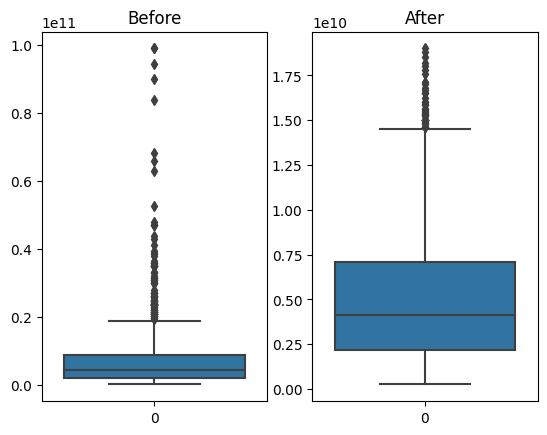

In [9]:
f, axes = plt.subplots(1, 2)
sns.boxplot(data=df['price2'],  orient='v' , ax=axes[0]).set_title('Before')
sns.boxplot(data=df1['price2'],  orient='v' , ax=axes[1]).set_title('After');

The right box plot is for new dataframe which has not outlier 

## dividing house price to different group (for classification)

In [10]:
conditions = [
    (df1['price2'] <= 3e9),
    (df1['price2'] > 3e9) & (df1['price2'] <= 6e9),
    (df1['price2'] > 6e9) & (df1['price2'] <= 9e9),
    (df1['price2'] > 9e9) & (df1['price2'] <= 12e9),
    (df1['price2'] > 12e9) & (df1['price2'] <= 15e9),
    (df1['price2'] > 15e9) 
    
    ]
values = [1,2,3,4,5,6]

df1['price_group'] = np.select(conditions, values)
df1

,District,District ID,house_type,parking,Elevator,Meterage,room,house_age,price2,price_group
0,آپادانا - خرمشهر,928,آپارتمان,1,1,120,2,0,1.200000e+10,4
1,آپادانا - خرمشهر,928,آپارتمان,0,0,35,0,21,1.300000e+09,1
3,آپادانا - خرمشهر,928,آپارتمان,1,1,117,2,1,1.088100e+10,4
4,آپادانا - خرمشهر,928,آپارتمان,1,1,87,2,10,7.000000e+09,3
5,آپادانا - خرمشهر,928,آپارتمان,1,1,130,3,0,1.500000e+10,5
...,...,...,...,...,...,...,...,...,...,...
924,باغ فیض,4667,آپارتمان,1,1,128,3,13,8.500000e+09,3
925,باغ فیض,4667,آپارتمان,1,1,93,2,16,6.100000e+09,3
926,باغ فیض,4667,آپارتمان,1,1,85,2,11,6.000000e+09,2
927,باغ فیض,4667,آپارتمان,1,1,138,3,0,9.000000e+09,3


## finding imbalanced class

In [23]:
df['house_type'].unique()

array(['آپارتمان', 'ویلا', 'خانه و کلنگی'], dtype=object)

In [11]:
temp=df1.groupby('price_group').count()
temp1=df1.groupby('room').count()
temp2=df1.groupby('parking').count()
temp3=df1.groupby('house_type').count()

In [38]:
temp3

,District,District ID,parking,Elevator,Meterage,room,house_age,price2,price_group
house_type,,,,,,,,,
آپارتمان,811,811,811,811,811,811,811,811,811
خانه و کلنگی,33,33,33,33,33,33,33,33,33
ویلا,2,2,2,2,2,2,2,2,2


<Figure size 640x480 with 0 Axes>

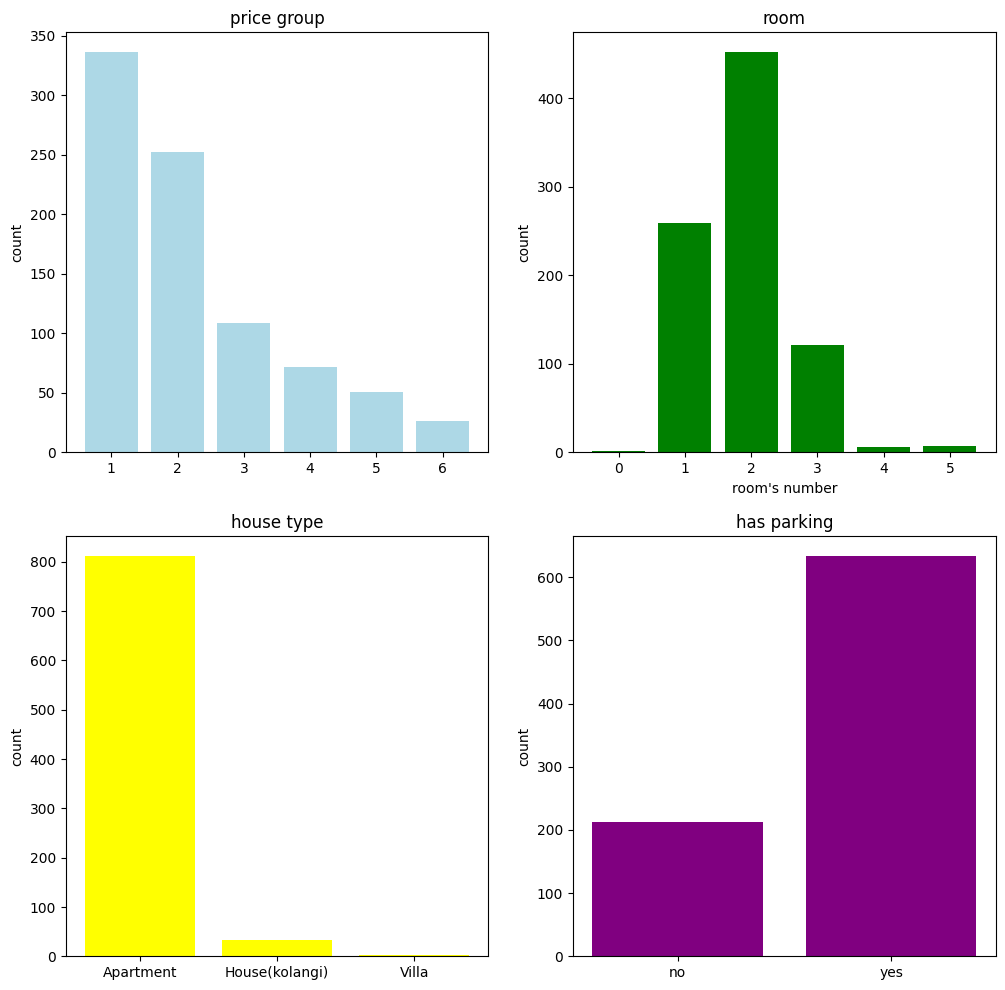

In [48]:
fig = plt.figure()
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
axes[0][0].bar(range(1,7),temp['price2'],color='lightblue')
axes[0][0].set_title('price group')
axes[0][0].set_ylabel('count')


axes[1][0].bar(['Apartment','House(kolangi)','Villa'],temp3['price2'],color='yellow')
axes[1][0].set_title('house type')
axes[1][0].set_ylabel('count')

axes[0][1].bar(range(0,6),temp1['price2'],color='green')
axes[0][1].set_title('room')
axes[0][1].set_ylabel('count')
axes[0][1].set_xlabel("room's number")

axes[1][1].bar(['no','yes',],temp2['price2'],color='purple')
axes[1][1].set_title('has parking')
axes[1][1].set_ylabel('count')


plt.show()

## using pd.get_dummies for encoding

In [90]:
df_nums = df1.select_dtypes(exclude='object')
df_objs = df1.select_dtypes(include='object')
df_objs = pd.get_dummies(df_objs)
df2 = pd.concat([df_nums,df_objs],axis=1)
df2

,District ID,parking,Elevator,Meterage,room,house_age,price2,price_group,District_۱۴ ﻪﻘﻄﻨﻣ - ﺭﺫﻮﺑﺍ,District_ﮓﻨﻫﺁ,...,District_ﻪﯾﺭﺎﯿﺘﺧﺍ,District_ﻪﯾﺮﯿﻣﺍ,District_ﻪﯾﺮﺴﻓﺍ,District_ﻪﯿﺳﺪﻗﺍ,District_ﻪﯿﻧﺍﺩﻮﺟﺁ,District_ﻪﯿﻬﻟﺍ,District_ﻮﮔﺯﺭﺪﻧﺍ,house_type_ﯽﮕﻨﻠﮐ ﻭ ﻪﻧﺎﺧ,house_type_ﻥﺎﻤﺗﺭﺎﭘﺁ,house_type_ﻼﯾﻭ
0,928,1,1,120,2,0,1.200000e+10,4,0,0,...,0,0,0,0,0,0,0,0,1,0
1,928,0,0,35,0,21,1.300000e+09,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,928,1,1,117,2,1,1.088100e+10,4,0,0,...,0,0,0,0,0,0,0,0,1,0
4,928,1,1,87,2,10,7.000000e+09,3,0,0,...,0,0,0,0,0,0,0,0,1,0
5,928,1,1,130,3,0,1.500000e+10,5,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,4667,1,1,128,3,13,8.500000e+09,3,0,0,...,0,0,0,0,0,0,0,0,1,0
925,4667,1,1,93,2,16,6.100000e+09,3,0,0,...,0,0,0,0,0,0,0,0,1,0
926,4667,1,1,85,2,11,6.000000e+09,2,0,0,...,0,0,0,0,0,0,0,0,1,0
927,4667,1,1,138,3,0,9.000000e+09,3,0,0,...,0,0,0,0,0,0,0,0,1,0


# Part 4. Visualization and EDA

Changing the format of District and house_type for plots

In [50]:
def persian_to_arabic(text):
    return get_display(reshape(text))

In [51]:
df1['District']=df1.apply(lambda row : persian_to_arabic(row['District']), axis = 1)
df1['house_type']=df1.apply(lambda row : persian_to_arabic(row['house_type']), axis = 1)

In [52]:
df1

,District,District ID,house_type,parking,Elevator,Meterage,room,house_age,price2,price_group
0,ﺮﻬﺸﻣﺮﺧ - ﺎﻧﺍﺩﺎﭘﺁ,928,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,120,2,0,1.200000e+10,4
1,ﺮﻬﺸﻣﺮﺧ - ﺎﻧﺍﺩﺎﭘﺁ,928,ﻥﺎﻤﺗﺭﺎﭘﺁ,0,0,35,0,21,1.300000e+09,1
3,ﺮﻬﺸﻣﺮﺧ - ﺎﻧﺍﺩﺎﭘﺁ,928,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,117,2,1,1.088100e+10,4
4,ﺮﻬﺸﻣﺮﺧ - ﺎﻧﺍﺩﺎﭘﺁ,928,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,87,2,10,7.000000e+09,3
5,ﺮﻬﺸﻣﺮﺧ - ﺎﻧﺍﺩﺎﭘﺁ,928,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,130,3,0,1.500000e+10,5
...,...,...,...,...,...,...,...,...,...,...
924,ﺾﯿﻓ ﻍﺎﺑ,4667,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,128,3,13,8.500000e+09,3
925,ﺾﯿﻓ ﻍﺎﺑ,4667,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,93,2,16,6.100000e+09,3
926,ﺾﯿﻓ ﻍﺎﺑ,4667,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,85,2,11,6.000000e+09,2
927,ﺾﯿﻓ ﻍﺎﺑ,4667,ﻥﺎﻤﺗﺭﺎﭘﺁ,1,1,138,3,0,9.000000e+09,3


## Correlation

,District ID,parking,Elevator,Meterage,room,house_age,price2,price_group
District ID,1.000000,0.113845,0.138669,0.056215,0.039113,-0.080468,0.086362,0.099924
parking,0.113845,1.000000,0.568250,0.023392,0.273458,-0.509405,0.356213,0.367201
Elevator,0.138669,0.568250,1.000000,0.027949,0.282940,-0.687812,0.364446,0.382450
Meterage,0.056215,0.023392,0.027949,1.000000,0.091608,-0.040276,0.055812,0.054360
room,0.039113,0.273458,0.282940,0.091608,1.000000,-0.177302,0.538918,0.514144
house_age,-0.080468,-0.509405,-0.687812,-0.040276,-0.177302,1.000000,-0.213125,-0.229093
price2,0.086362,0.356213,0.364446,0.055812,0.538918,-0.213125,1.000000,0.980202
price_group,0.099924,0.367201,0.382450,0.054360,0.514144,-0.229093,0.980202,1.000000


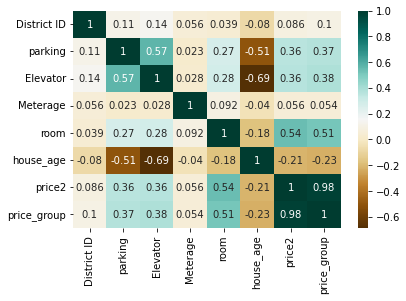

In [149]:
sns.heatmap(df1.corr(),cmap="BrBG",annot=True)
df1.corr()

In [150]:
df1.corr()['price_group'].sort_values()

house_age     -0.229093
Meterage       0.054360
District ID    0.099924
parking        0.367201
Elevator       0.382450
room           0.514144
price2         0.980202
price_group    1.000000
Name: price_group, dtype: float64

## Random Forest Regressor

In [53]:
df_rfr_x=df1[['house_age','Meterage','parking','Elevator','room','District','house_type']]

le_District=preprocessing.LabelEncoder()
le_District.fit(df1.District.unique())
df_rfr_x.iloc[:,5]=le_District.transform(df_rfr_x.iloc[:,5])

le_house_type=preprocessing.LabelEncoder()
le_house_type.fit(df1.house_type.unique())
df_rfr_x.iloc[:,6]=le_house_type.transform(df_rfr_x.iloc[:,6])

In [152]:
df_rfr_x

,house_age,Meterage,parking,Elevator,room,District,house_type
0,0,120,1,1,2,12,1
1,21,35,0,0,0,12,1
3,1,117,1,1,2,12,1
4,10,87,1,1,2,12,1
5,0,130,1,1,3,12,1
...,...,...,...,...,...,...,...
924,13,128,1,1,3,13,1
925,16,93,1,1,2,13,1
926,11,85,1,1,2,13,1
927,0,138,1,1,3,13,1


In [57]:
X_train, X_test, y_train, y_test = train_test_split( df_rfr_x, df1.price_group, test_size=0.20, random_state=42)

In [58]:
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 7, random_state=0)

rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=500,
                      random_state=0)

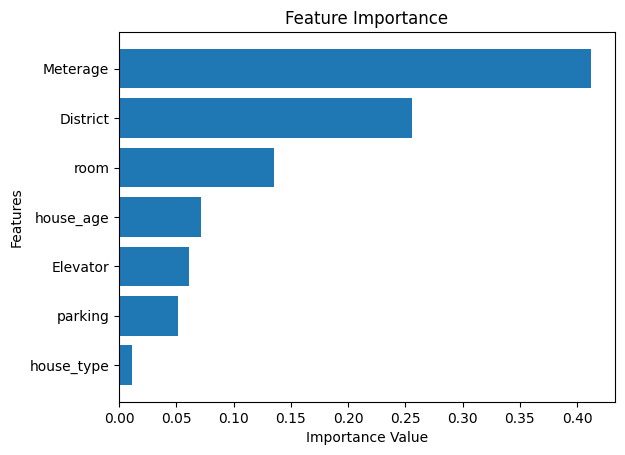

In [59]:
f_i = list(zip(df_rfr_x.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.xlabel("Importance Value")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

## Barplot of Price in different price groups

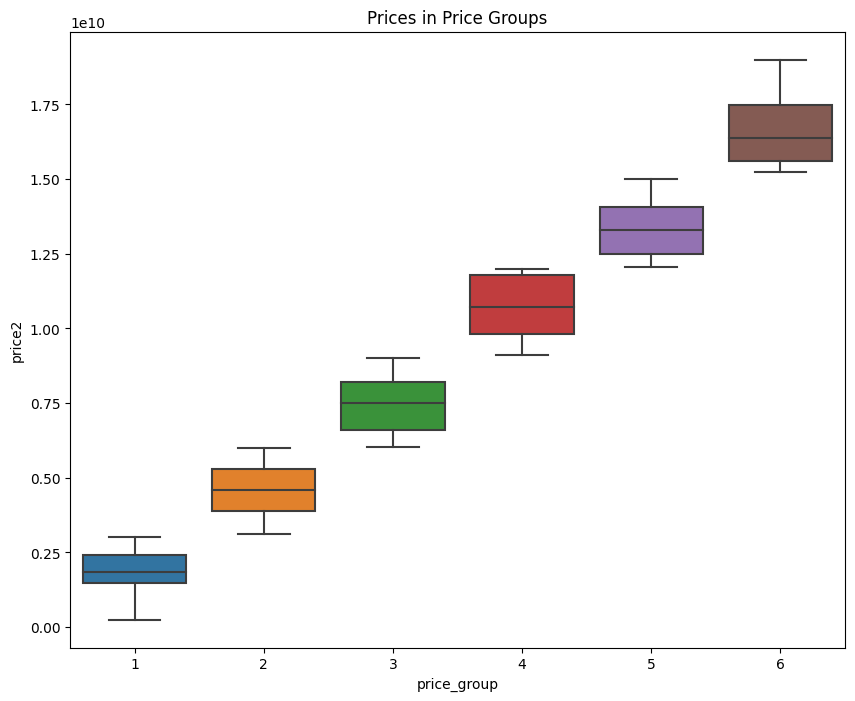

In [60]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax,x="price_group", y="price2", data=df1).set_title('Prices in Price Groups');

## Number of rooms in each price group

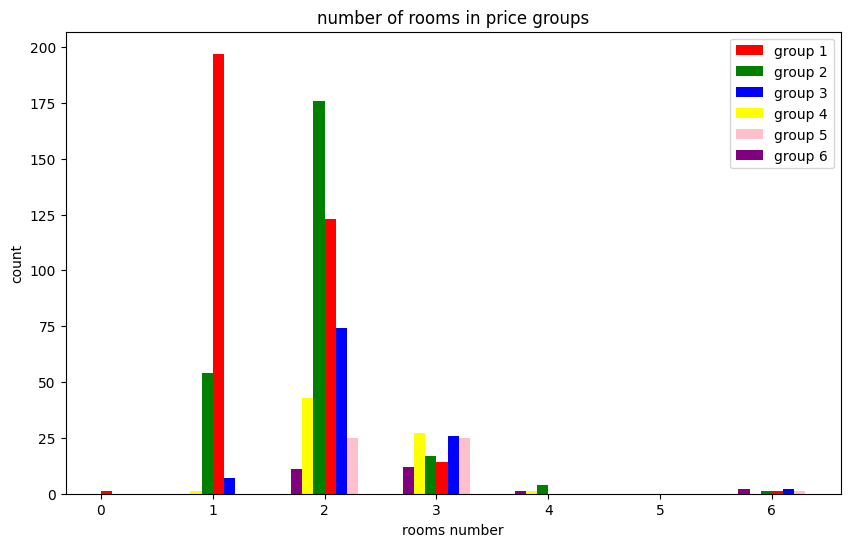

In [61]:
fig = plt.figure(figsize = (10,6))
plt.bar(df1.loc[df1.price_group==1].sort_values(by=['room']).room.unique()+0.05, df1.loc[df1.price_group==1].groupby(['room']).room.count().values,color='red',label='group 1',width=0.1)
plt.bar(df1.loc[df1.price_group==2].sort_values(by=['room']).room.unique()-0.05, df1.loc[df1.price_group==2].groupby(['room']).room.count().values,color='green',label='group 2',width=0.1)
plt.bar(df1.loc[df1.price_group==3].sort_values(by=['room']).room.unique()+0.15, df1.loc[df1.price_group==3].groupby(['room']).room.count().values,color='blue',label='group 3',width=0.1)
plt.bar(df1.loc[df1.price_group==4].sort_values(by=['room']).room.unique()-0.15, df1.loc[df1.price_group==4].groupby(['room']).room.count().values,color='yellow',label='group 4',width=0.1)
plt.bar(df1.loc[df1.price_group==5].sort_values(by=['room']).room.unique()+0.25, df1.loc[df1.price_group==5].groupby(['room']).room.count().values,color='pink',label='group 5',width=0.1)
plt.bar(df1.loc[df1.price_group==6].sort_values(by=['room']).room.unique()-0.25, df1.loc[df1.price_group==6].groupby(['room']).room.count().values,color='purple',label='group 6',width=0.1)

plt.xlabel("rooms number")
plt.ylabel("count")
plt.title("number of rooms in price groups")
plt.legend()
plt.show()

## Boxplot of Meterage per Price groups

Text(0.5, 1.0, 'Meterage per Price groups')

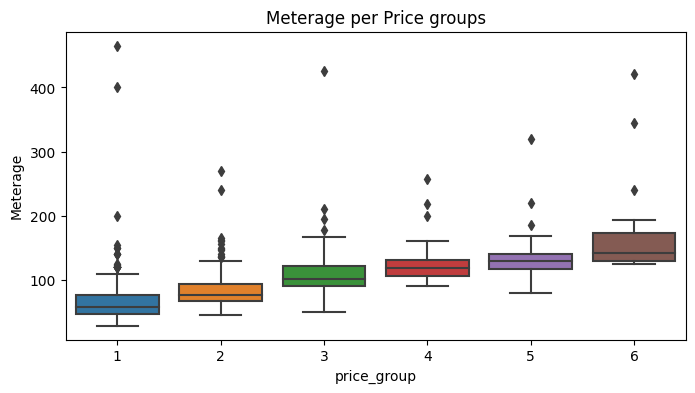

In [62]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax,x="price_group", y="Meterage", data=df1.loc[df1.Meterage<5000]).set_title('Meterage per Price groups')

## Number of houses in each District per price groups

Text(0.5, 1.0, 'Count of price group 6 in each district')

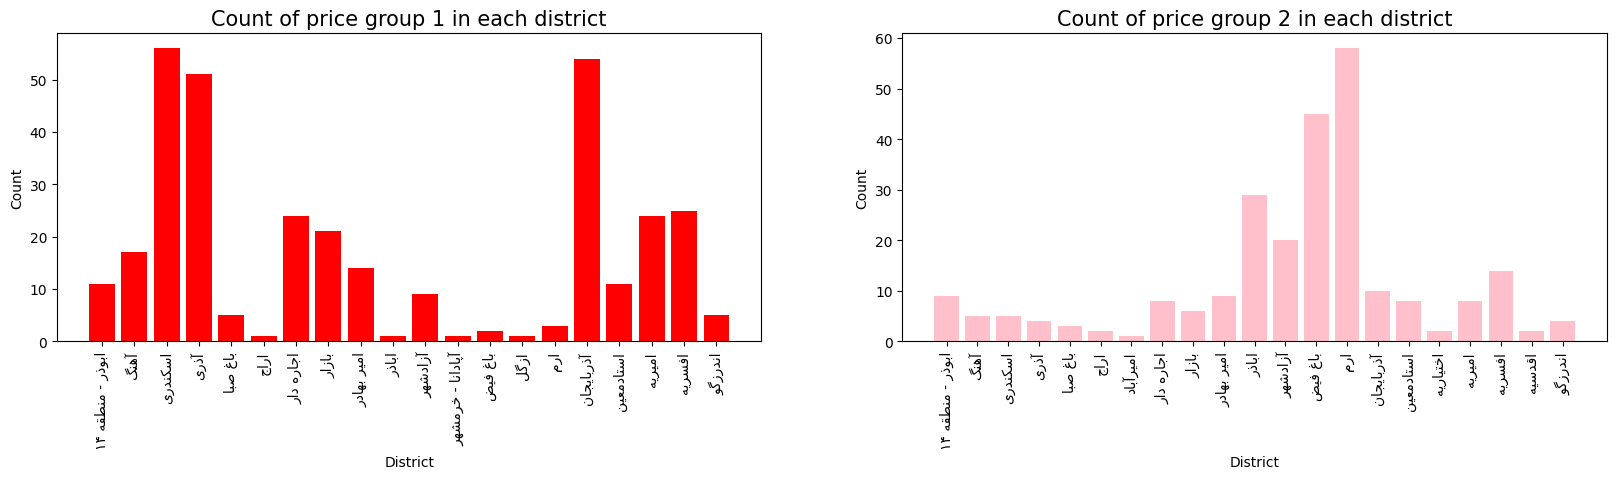

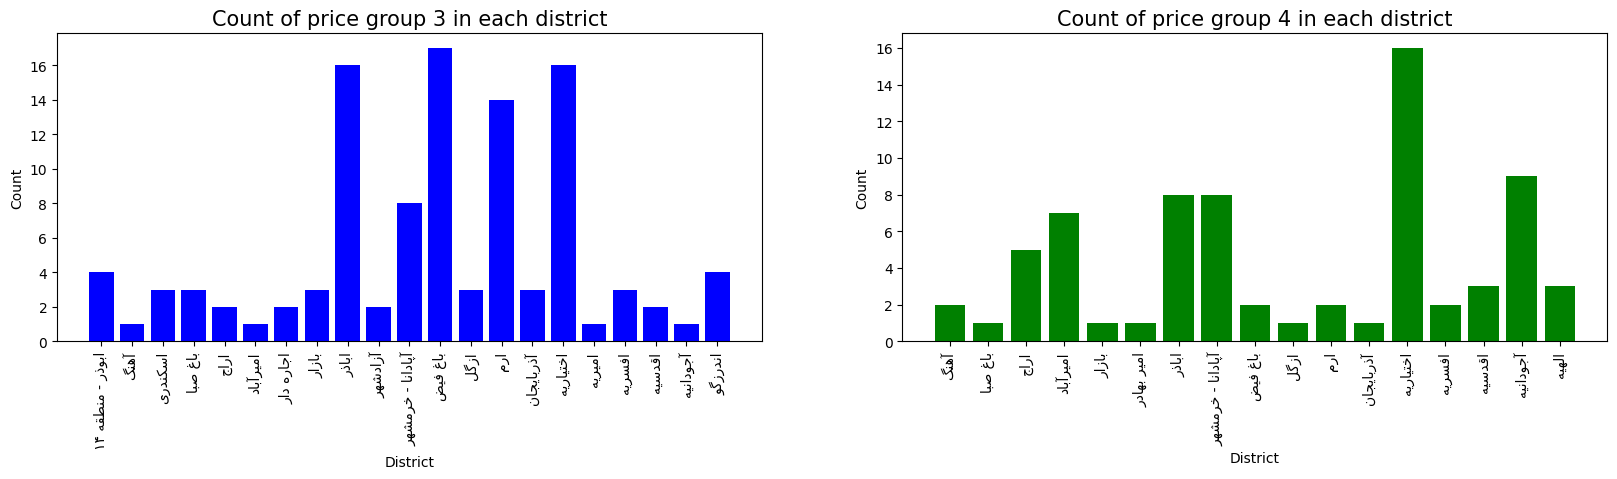

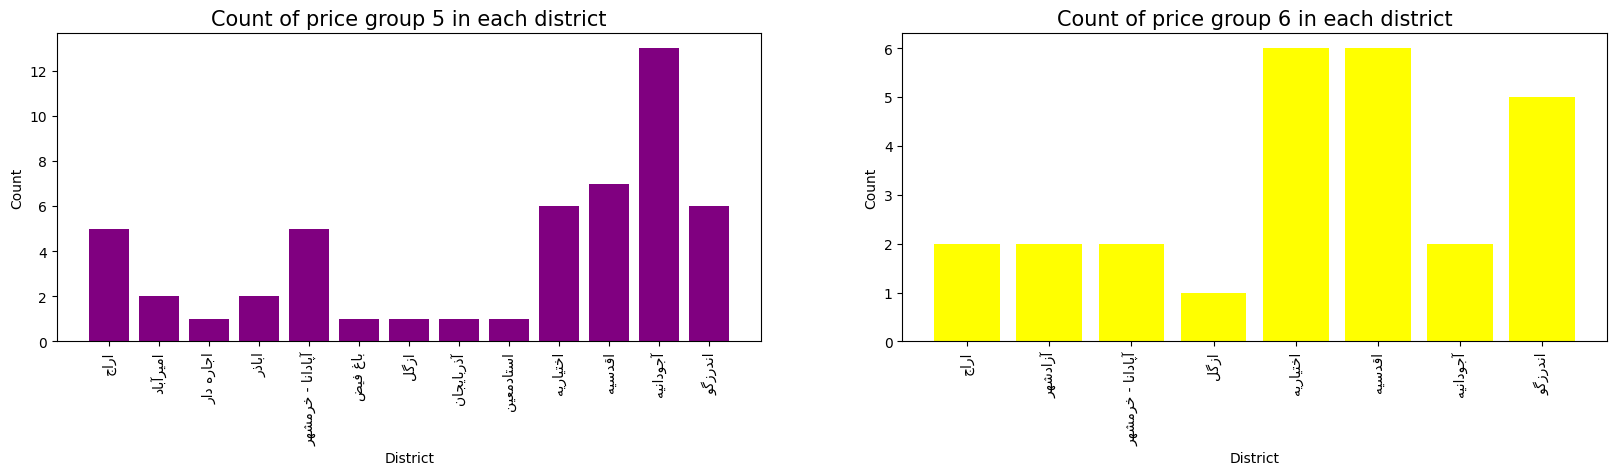

In [63]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(20)

ax1.bar(df1.loc[df1.price_group==1].sort_values(by=['District']).District.unique(), df1.loc[df1.price_group==1].groupby(['District']).District.count().values,color='red',label='group 1')
ax1.set(xlabel='District',ylabel='Count')
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_title("Count of price group 1 in each district", size=15)

ax2.bar(df1.loc[df1.price_group==2].sort_values(by=['District']).District.unique(), df1.loc[df1.price_group==2].groupby(['District']).District.count().values,color='pink',label='group 2')
ax2.set(xlabel='District',ylabel='Count')
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_title("Count of price group 2 in each district", size=15)

fig, (ax3,ax4) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(20)

ax3.bar(df1.loc[df1.price_group==3].sort_values(by=['District']).District.unique(), df1.loc[df1.price_group==3].groupby(['District']).District.count().values,color='blue',label='group 3')
ax3.set(xlabel='District',ylabel='Count')
ax3.tick_params(axis='x', labelrotation=90)
ax3.set_title("Count of price group 3 in each district", size=15)

ax4.bar(df1.loc[df1.price_group==4].sort_values(by=['District']).District.unique(), df1.loc[df1.price_group==4].groupby(['District']).District.count().values,color='green',label='group 4')
ax4.set(xlabel='District',ylabel='Count')
ax4.tick_params(axis='x', labelrotation=90)
ax4.set_title("Count of price group 4 in each district", size=15)

fig, (ax5,ax6) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(20)

ax5.bar(df1.loc[df1.price_group==5].sort_values(by=['District']).District.unique(), df1.loc[df1.price_group==5].groupby(['District']).District.count().values,color='purple',label='group 5')
ax5.set(xlabel='District',ylabel='Count')
ax5.tick_params(axis='x', labelrotation=90)
ax5.set_title("Count of price group 5 in each district", size=15)

ax6.bar(df1.loc[df1.price_group==6].sort_values(by=['District']).District.unique(), df1.loc[df1.price_group==6].groupby(['District']).District.count().values,color='yellow',label='group 6')
ax6.set(xlabel='District',ylabel='Count')
ax6.tick_params(axis='x', labelrotation=90)
ax6.set_title("Count of price group 6 in each district", size=15)

##  House Age per price groups

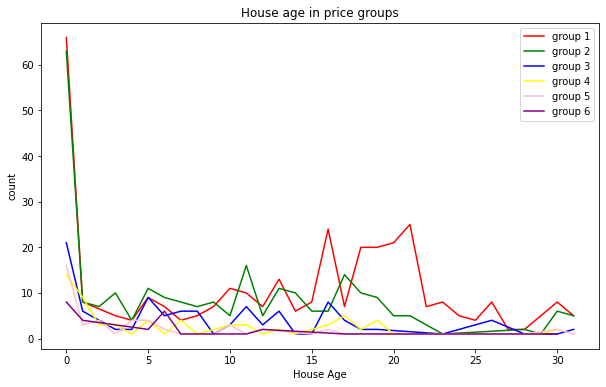

In [160]:
fig = plt.figure(figsize = (10,6))
plt.plot(df1.loc[df1.price_group==1].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.price_group==1].groupby(['house_age']).house_age.count().values,color='red',label='group 1')
plt.plot(df1.loc[df1.price_group==2].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.price_group==2].groupby(['house_age']).house_age.count().values,color='green',label='group 2')
plt.plot(df1.loc[df1.price_group==3].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.price_group==3].groupby(['house_age']).house_age.count().values,color='blue',label='group 3')
plt.plot(df1.loc[df1.price_group==4].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.price_group==4].groupby(['house_age']).house_age.count().values,color='yellow',label='group 4')
plt.plot(df1.loc[df1.price_group==5].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.price_group==5].groupby(['house_age']).house_age.count().values,color='pink',label='group 5')
plt.plot(df1.loc[df1.price_group==6].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.price_group==6].groupby(['house_age']).house_age.count().values,color='purple',label='group 6')

plt.xlabel("House Age")
plt.ylabel("count")
plt.title("House age in price groups")
plt.legend()
plt.show()

## Number of houses with or without elevator in different price groups

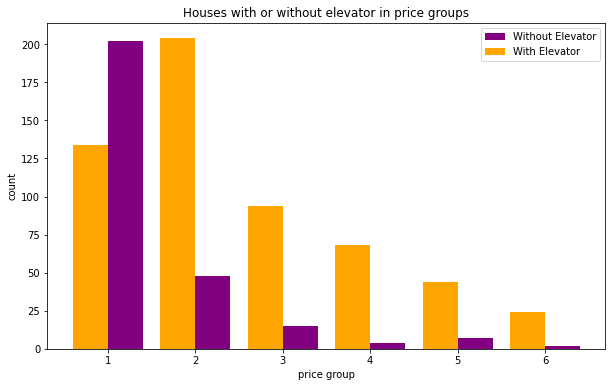

In [161]:
fig = plt.figure(figsize = (10,6))
plt.bar(df1.loc[df1.Elevator==0].sort_values(by=['price_group']).price_group.unique()+0.2, df1.loc[df1.Elevator==0].groupby(['price_group']).price_group.count().values,color='purple',label='Without Elevator',width=0.4)
plt.bar(df1.loc[df1.Elevator==1].sort_values(by=['price_group']).price_group.unique()-0.2, df1.loc[df1.Elevator==1].groupby(['price_group']).price_group.count().values,color='orange',label='With Elevator',width=0.4)

plt.xlabel("price group")
plt.ylabel("count")
plt.title("Houses with or without elevator in price groups")
plt.legend()
plt.show()

## Number of houses with or without parking in different price groups

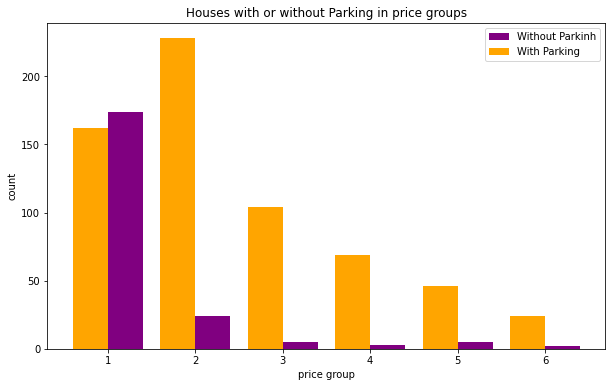

In [162]:
fig = plt.figure(figsize = (10,6))
plt.bar(df1.loc[df1.parking==0].sort_values(by=['price_group']).price_group.unique()+0.2, df1.loc[df1.parking==0].groupby(['price_group']).price_group.count().values,color='purple',label='Without Parkinh',width=0.4)
plt.bar(df1.loc[df1.parking==1].sort_values(by=['price_group']).price_group.unique()-0.2, df1.loc[df1.parking==1].groupby(['price_group']).price_group.count().values,color='orange',label='With Parking',width=0.4)

plt.xlabel("price group")
plt.ylabel("count")
plt.title("Houses with or without Parking in price groups")
plt.legend()
plt.show()

## Number of each house type per price groups

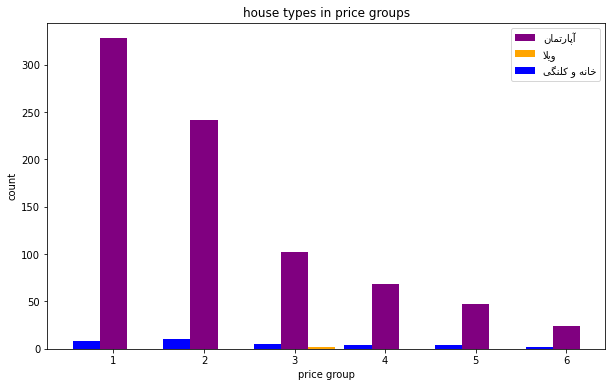

In [163]:
house_types=df1.house_type.unique()

fig = plt.figure(figsize = (10,6))
plt.bar(df1.loc[df1.house_type==house_types[0]].sort_values(by=['price_group']).price_group.unique(), df1.loc[df1.house_type==house_types[0]].groupby(['price_group']).price_group.count().values,color='purple',label=house_types[0],width=0.3)
plt.bar(df1.loc[df1.house_type==house_types[1]].sort_values(by=['price_group']).price_group.unique()+0.3, df1.loc[df1.house_type==house_types[1]].groupby(['price_group']).price_group.count().values,color='orange',label=house_types[1],width=0.3)
plt.bar(df1.loc[df1.house_type==house_types[2]].sort_values(by=['price_group']).price_group.unique()-0.3, df1.loc[df1.house_type==house_types[2]].groupby(['price_group']).price_group.count().values,color='blue',label=house_types[2],width=0.3)

plt.xlabel("price group")
plt.ylabel("count")
plt.title("house types in price groups")
plt.legend()
plt.show()

## Number of Elevators per house age

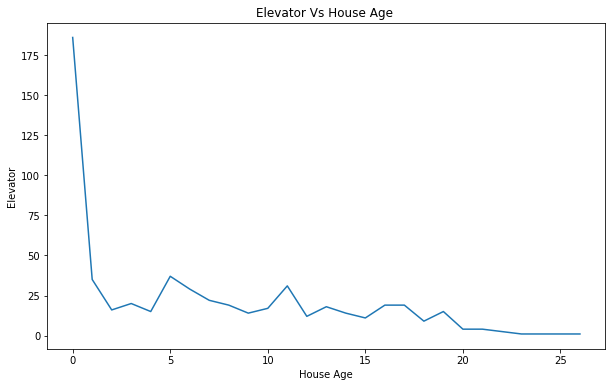

In [164]:
fig = plt.figure(figsize = (10,6))
plt.plot(df1.loc[df1.Elevator==1].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.Elevator==1].groupby(['house_age']).house_age.count().values)

plt.xlabel("House Age")
plt.ylabel("Elevator")
plt.title("Elevator Vs House Age ")
plt.show();

## Number of parkings per house age

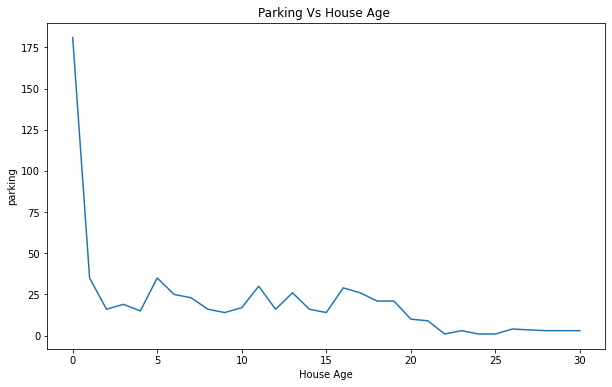

In [165]:
fig = plt.figure(figsize = (10,6))
plt.plot(df1.loc[df1.parking==1].sort_values(by=['house_age']).house_age.unique(), df1.loc[df1.parking==1].groupby(['house_age']).house_age.count().values)

plt.xlabel("House Age")
plt.ylabel("parking")
plt.title("Parking Vs House Age ")
plt.show();

# Part 5. Feature Selection and Dimention Reduction 

In [91]:
df_pca_x=df2.copy(deep=True)
df_pca_x=df_pca_x.drop(['District ID', 'price2','price_group'], axis=1)
df_pca_x

,parking,Elevator,Meterage,room,house_age,District_۱۴ ﻪﻘﻄﻨﻣ - ﺭﺫﻮﺑﺍ,District_ﮓﻨﻫﺁ,District_ﯼﺭﺪﻨﮑﺳﺍ,District_ﯼﺭﺫﺁ,District_ﺎﺒﺻ ﻍﺎﺑ,...,District_ﻪﯾﺭﺎﯿﺘﺧﺍ,District_ﻪﯾﺮﯿﻣﺍ,District_ﻪﯾﺮﺴﻓﺍ,District_ﻪﯿﺳﺪﻗﺍ,District_ﻪﯿﻧﺍﺩﻮﺟﺁ,District_ﻪﯿﻬﻟﺍ,District_ﻮﮔﺯﺭﺪﻧﺍ,house_type_ﯽﮕﻨﻠﮐ ﻭ ﻪﻧﺎﺧ,house_type_ﻥﺎﻤﺗﺭﺎﭘﺁ,house_type_ﻼﯾﻭ
0,1,1,120,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,35,0,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,117,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,87,2,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,1,130,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,1,1,128,3,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
925,1,1,93,2,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
926,1,1,85,2,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
927,1,1,138,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [86]:
df_rfr_x

,house_age,Meterage,parking,Elevator,room,District,house_type
0,0,120,1,1,2,12,1
1,21,35,0,0,0,12,1
3,1,117,1,1,2,12,1
4,10,87,1,1,2,12,1
5,0,130,1,1,3,12,1
...,...,...,...,...,...,...,...
924,13,128,1,1,3,13,1
925,16,93,1,1,2,13,1
926,11,85,1,1,2,13,1
927,0,138,1,1,3,13,1


In [96]:
df_nums1 = df_rfr_x.select_dtypes(exclude='object')
df_objs1 = df_rfr_x.select_dtypes(include='object')
df_objs1 = pd.get_dummies(df_objs)
df_temp = pd.concat([df_nums1,df_objs1],axis=1)
df_temp

,house_age,Meterage,parking,Elevator,room,District,house_type,District_۱۴ ﻪﻘﻄﻨﻣ - ﺭﺫﻮﺑﺍ,District_ﮓﻨﻫﺁ,District_ﯼﺭﺪﻨﮑﺳﺍ,...,District_ﻪﯾﺭﺎﯿﺘﺧﺍ,District_ﻪﯾﺮﯿﻣﺍ,District_ﻪﯾﺮﺴﻓﺍ,District_ﻪﯿﺳﺪﻗﺍ,District_ﻪﯿﻧﺍﺩﻮﺟﺁ,District_ﻪﯿﻬﻟﺍ,District_ﻮﮔﺯﺭﺪﻧﺍ,house_type_ﯽﮕﻨﻠﮐ ﻭ ﻪﻧﺎﺧ,house_type_ﻥﺎﻤﺗﺭﺎﭘﺁ,house_type_ﻼﯾﻭ
0,0,120,1,1,2,12,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,21,35,0,0,0,12,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,117,1,1,2,12,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10,87,1,1,2,12,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,130,1,1,3,12,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,13,128,1,1,3,13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
925,16,93,1,1,2,13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
926,11,85,1,1,2,13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
927,0,138,1,1,3,13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Text(0, 0.5, 'Second Principal Component')

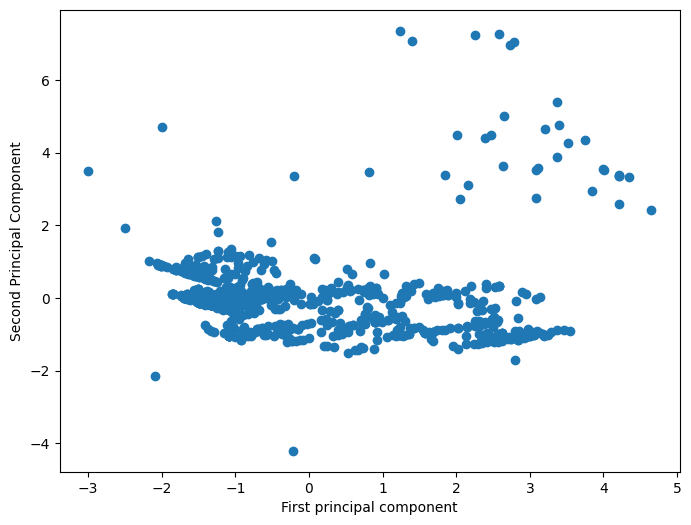

In [99]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df_rfr_x)
a=[]
for i in range (1,6):
    pca = PCA(n_components=i)
    principal_components = pca.fit_transform(scaled_X)
    a.append(pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
plt.scatter(principal_components[:,0],principal_components[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

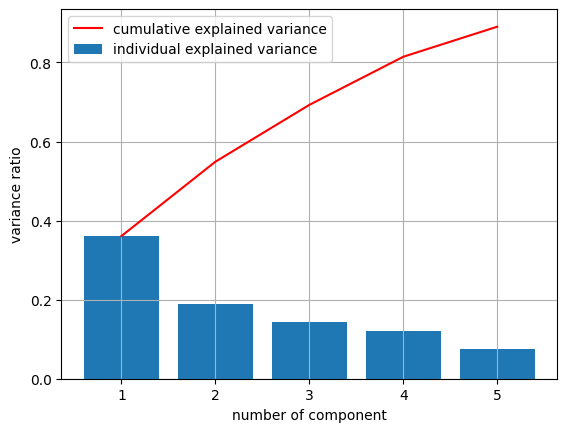

In [100]:
cumulative_var=[0]*5
cumulative_var[0]=a[4][0]
cumulative_var[1]=cumulative_var[0]+a[4][1]
cumulative_var[2]=cumulative_var[1]+a[4][2]
cumulative_var[3]=cumulative_var[2]+a[4][3]
cumulative_var[4]=cumulative_var[3]+a[4][4]
plt.bar(range(1,6),a[4])
plt.plot(range(1,6),cumulative_var ,color='red')
plt.xlabel("number of component")
plt.ylabel("variance ratio")
plt.legend(['cumulative explained variance','individual explained variance'])
plt.grid()

In [89]:
pca.explained_variance_ratio_

array([0.36078633, 0.18800854, 0.14377456, 0.12175522, 0.07600534])

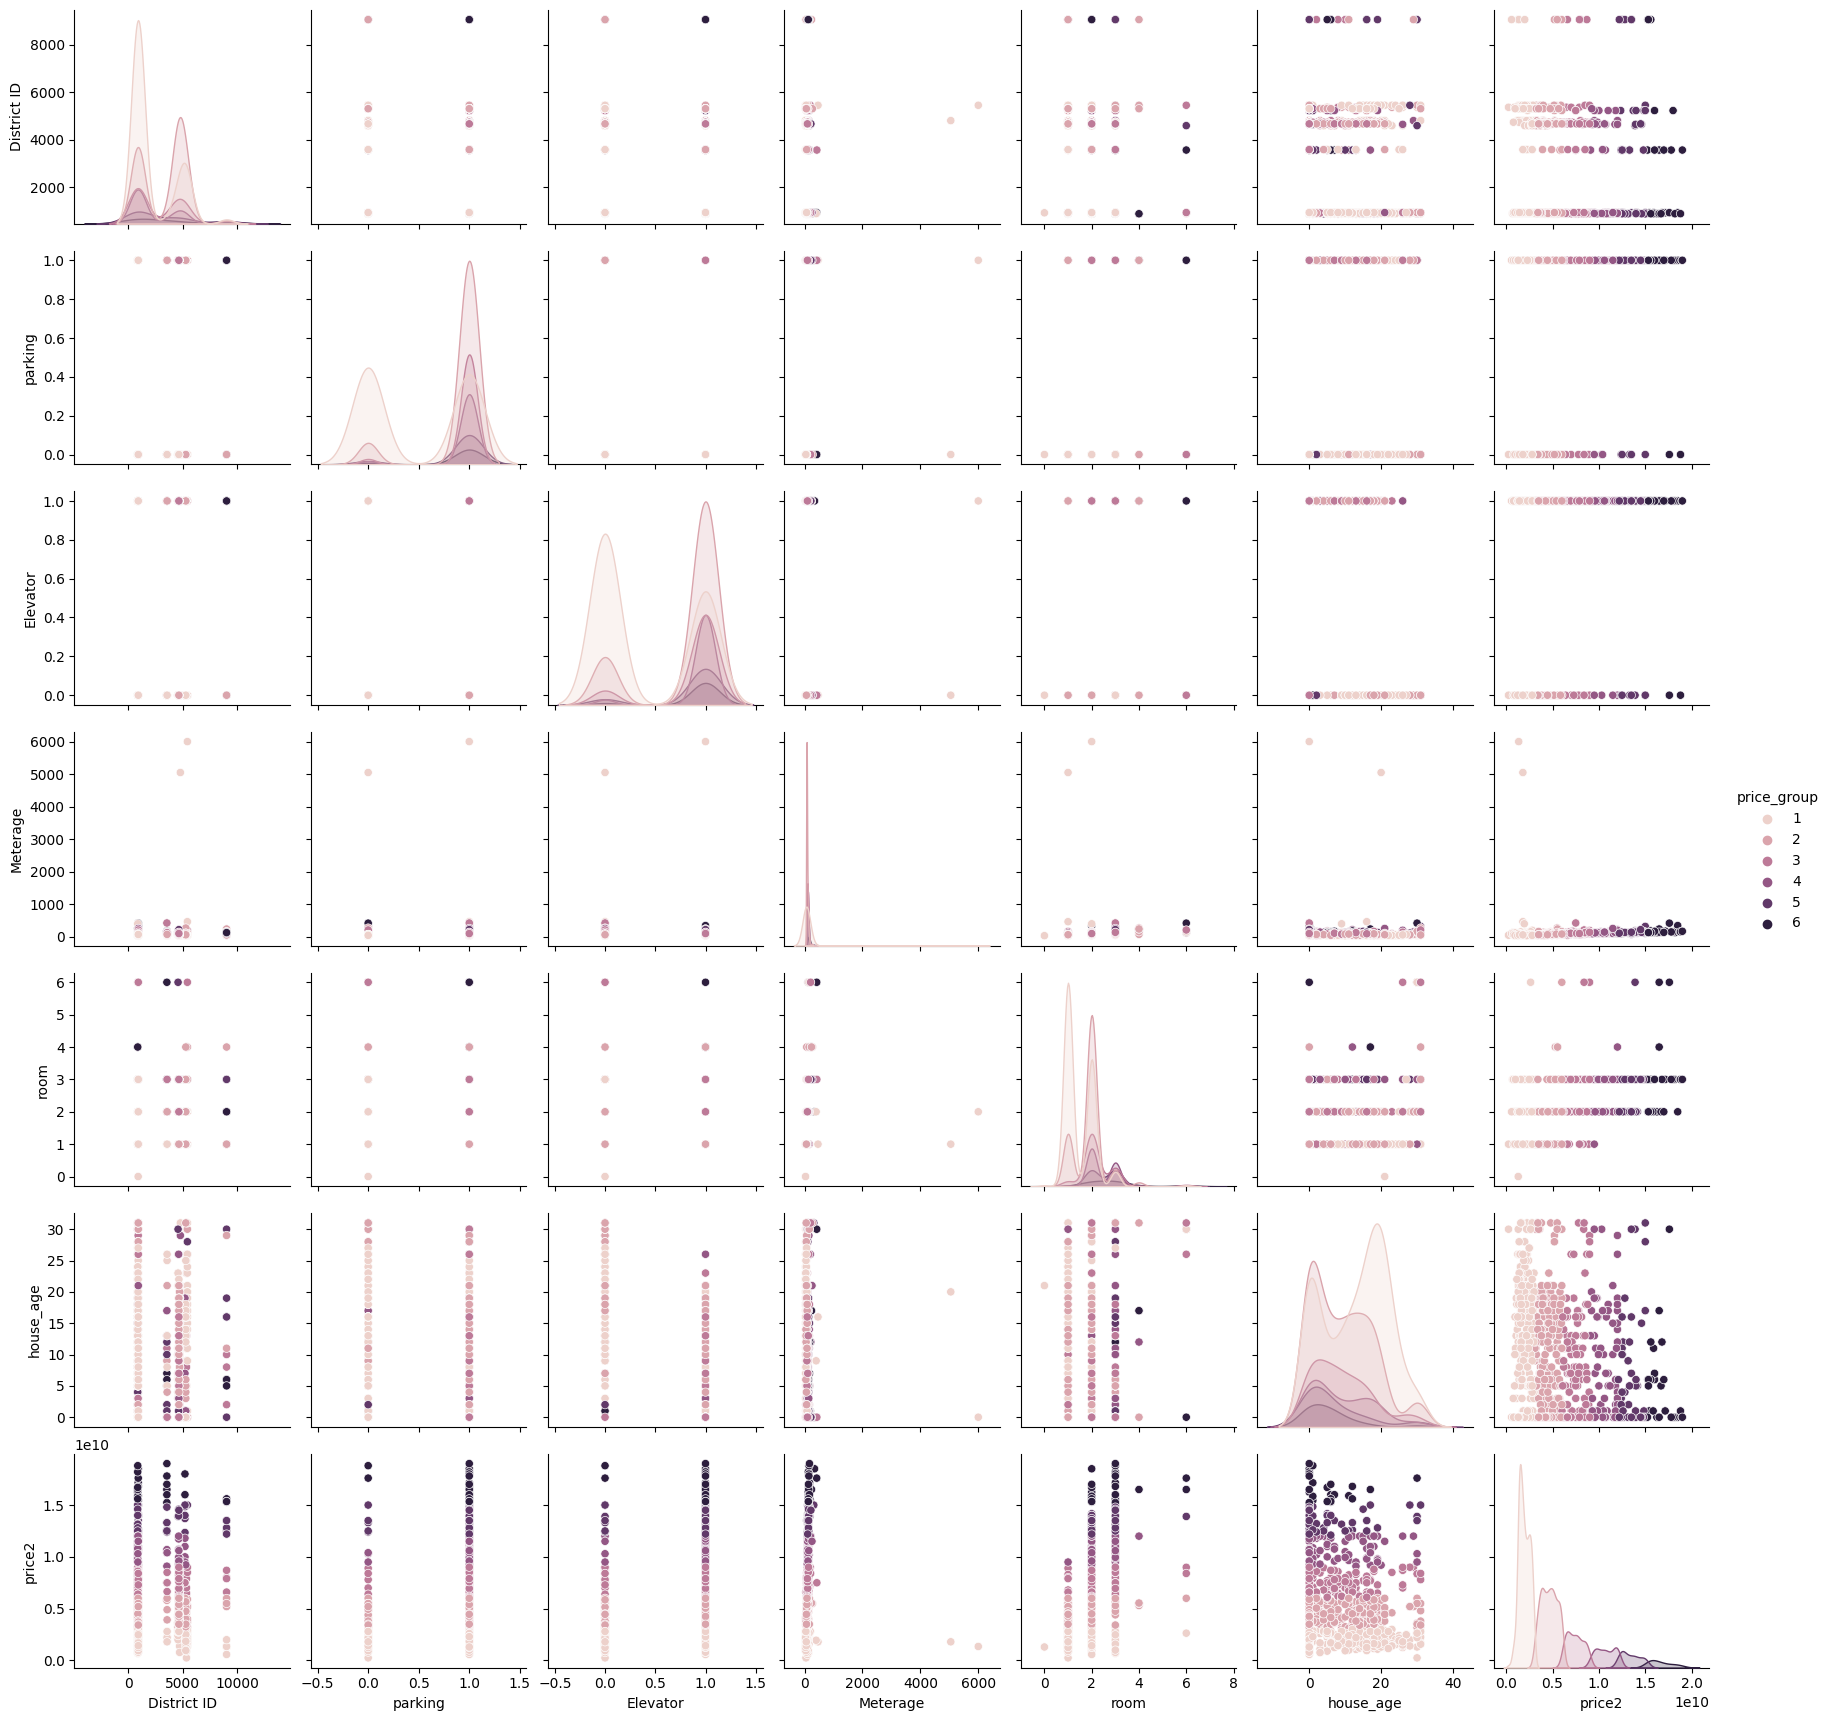

In [115]:
import seaborn as sns
sns.pairplot(df1,hue='price_group')

In [92]:
colors = ['royalblue','red','deeppink', 'maroon', 'mediumorchid', 'tan']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

## PCA

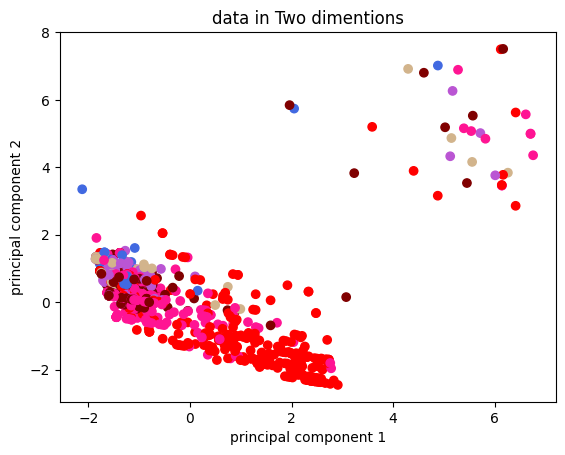

In [107]:
features =df_pca_x.columns
# Separating out the features
x = df_pca_x.loc[:, features].values
# Separating out the target
y = df2.loc[:,['price_group']].values.reshape((1, len(x)))[0]
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'],c=vectorizer(y))
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.title("data in Two dimentions")
plt.show()

In [108]:
pca.explained_variance_ratio_


array([0.09330212, 0.06534734])

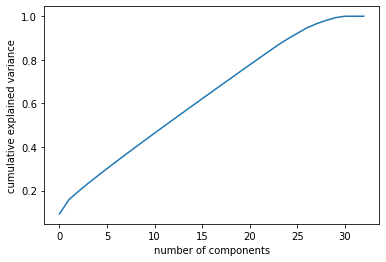

In [169]:
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## TSNE

In [170]:
X_embedded = TSNE(n_components=2, perplexity=30, n_iter = 4000).fit_transform(x)
X_embedded.shape

(846, 2)

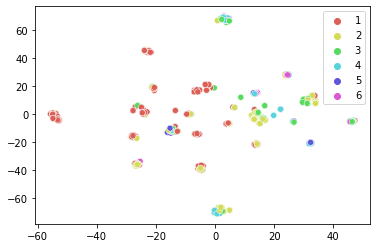

In [171]:
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y, palette = sns.hls_palette(6), legend = 'full');

## Final Dataframe after removing District ID wich was redundant

In [172]:
df_final=df2.copy(deep=True)
df_final=df_final.drop(['District ID', 'price2'], axis=1)
df_final

,parking,Elevator,Meterage,room,house_age,price_group,District_آجودانیه,District_آذربایجان,District_آذری,District_آزادشهر,...,District_امیر بهادر,District_امیرآباد,District_امیریه,District_اندرزگو,District_بازار,District_باغ صبا,District_باغ فیض,house_type_آپارتمان,house_type_خانه و کلنگی,house_type_ویلا
0,1,1,120,2,0,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,35,0,21,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,117,2,1,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,87,2,10,3,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,1,130,3,0,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,1,1,128,3,13,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
925,1,1,93,2,16,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
926,1,1,85,2,11,2,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
927,1,1,138,3,0,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [173]:
df_final.to_csv("final_data.csv", encoding='utf-8', index=False)

# Part 6. Classification Methods

In [3]:
df_final=pd.read_csv('final_data.csv')
df_final

,parking,Elevator,Meterage,room,house_age,price_group,District_آجودانیه,District_آذربایجان,District_آذری,District_آزادشهر,...,District_امیر بهادر,District_امیرآباد,District_امیریه,District_اندرزگو,District_بازار,District_باغ صبا,District_باغ فیض,house_type_آپارتمان,house_type_خانه و کلنگی,house_type_ویلا
0,1,1,120,2,0,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,35,0,21,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,117,2,1,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,87,2,10,3,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,130,3,0,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,1,1,128,3,13,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
842,1,1,93,2,16,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
843,1,1,85,2,11,2,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
844,1,1,138,3,0,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [102]:
df_classification_x=df_final.copy(deep=True)
df_classification_x=df_classification_x.drop(['price_group'], axis=1)
df_classification_x

,parking,Elevator,Meterage,room,house_age,District_آجودانیه,District_آذربایجان,District_آذری,District_آزادشهر,District_آهنگ,...,District_امیر بهادر,District_امیرآباد,District_امیریه,District_اندرزگو,District_بازار,District_باغ صبا,District_باغ فیض,house_type_آپارتمان,house_type_خانه و کلنگی,house_type_ویلا
0,1,1,120,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,35,0,21,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,117,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,87,2,10,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,130,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,1,1,128,3,13,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
842,1,1,93,2,16,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
843,1,1,85,2,11,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
844,1,1,138,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


## train test split

In [176]:
X_train, X_test, y_train,y_test = train_test_split(df_classification_x, df_final.price_group, test_size=0.2, random_state=42,stratify=df_final.price_group)

In [177]:
def All_metrics(y_test,y_pred, list_metrics, model_name):
    # Append All metrics to dataframe when model_name is use for index of dataframe
    list_metrics.loc[model_name,'Accuracy'] = metrics.accuracy_score(y_test,y_pred)
    list_metrics.loc[model_name,'Precision'] = metrics.precision_score(y_test,y_pred,average='weighted')
    list_metrics.loc[model_name,'Recall'] = metrics.recall_score(y_test,y_pred,average='weighted')
    list_metrics.loc[model_name,'F1'] = metrics.f1_score(y_test,y_pred,average='weighted')
    return list_metrics

In [178]:
list_metrics=pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])

## Logistic Regression

In [179]:
def Logistic_Regression_def(X_train, y_train, X_test, y_test, list_metrics):
    # create an instance of the logistic regression model
    log_reg = LogisticRegression()

    # fit the model to the training data
    log_reg.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = log_reg.predict(X_test)

    # evaluate the model's performance
    list_metrics = All_metrics(y_test,y_pred, list_metrics=list_metrics, model_name='Logistic-Regression')
    return list_metrics

In [180]:
Logistic_Regression_def(X_train, y_train, X_test, y_test, list_metrics)

,Accuracy,Precision,Recall,F1
Logistic-Regression,0.529412,0.43726,0.529412,0.458045


# mohsen

In [117]:
# df_final

In [118]:
X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)
# Penalty Type
penalty = ['l1', 'l2']

# Use logarithmically spaced C values (recommended in official docs)
C = np.logspace(0, 4, 10)
grid_model = GridSearchCV(log_model,param_grid={'C':C,'penalty':penalty})
grid_model.fit(scaled_X_train,y_train)
grid_model.best_params_

{'C': 59.94842503189409, 'penalty': 'l1'}

In [119]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
y_pred = grid_model.predict(scaled_X_test)
accuracy_score(y_test,y_pred)

0.6745283018867925

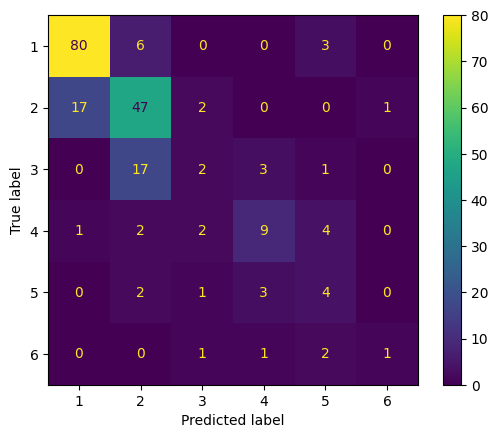

In [120]:
plot_confusion_matrix(grid_model,scaled_X_test,y_test)

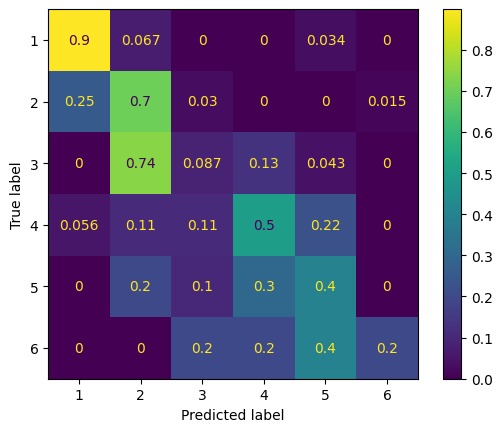

In [125]:
plot_confusion_matrix(grid_model,scaled_X_test,y_test,normalize='true')

In [128]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.82      0.90      0.86        89
           2       0.64      0.70      0.67        67
           3       0.25      0.09      0.13        23
           4       0.56      0.50      0.53        18
           5       0.29      0.40      0.33        10
           6       0.50      0.20      0.29         5

    accuracy                           0.67       212
   macro avg       0.51      0.46      0.47       212
weighted avg       0.64      0.67      0.65       212



## SVM

In [181]:
def SVM_def(kernel_name, X_train, y_train, X_test, y_test, list_metrics):
    # create an instance of the SVM model
    svm = SVC(kernel=kernel_name)

    # fit the model to the training data
    svm.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = svm.predict(X_test)

    # evaluate the model's performance
    list_metrics = All_metrics(y_test,y_pred, list_metrics=list_metrics, model_name='SVM-'+kernel_name)
    return list_metrics

In [182]:
list_metrics = SVM_def('linear', X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'SVM-linear']

,Accuracy,Precision,Recall,F1
SVM-linear,0.705882,0.71494,0.705882,0.703786


In [183]:
list_metrics = SVM_def('poly', X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'SVM-poly']

,Accuracy,Precision,Recall,F1
SVM-poly,0.4,0.16,0.4,0.228571


In [184]:
list_metrics = SVM_def('rbf', X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'SVM-rbf']

,Accuracy,Precision,Recall,F1
SVM-rbf,0.4,0.274153,0.4,0.325068


In [185]:
list_metrics = SVM_def('sigmoid', X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'SVM-sigmoid']

,Accuracy,Precision,Recall,F1
SVM-sigmoid,0.417647,0.250412,0.417647,0.307245


# mohsen

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix


X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = SVC(kernel='linear', C=2000)
model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)
accuracy_score(y_test,y_pred)


0.7216981132075472

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.80      0.88      0.84        89
           2       0.70      0.67      0.69        67
           3       0.62      0.57      0.59        23
           4       0.65      0.61      0.63        18
           5       0.40      0.40      0.40        10
           6       0.67      0.40      0.50         5

    accuracy                           0.72       212
   macro avg       0.64      0.59      0.61       212
weighted avg       0.72      0.72      0.72       212



## Decision Tree

In [186]:
def Decision_Tree_def(criterion_name, X_train, y_train, X_test, y_test, list_metrics):
# create an instance of the decision tree model
    dt = DecisionTreeClassifier(criterion=criterion_name)

    # fit the model to the training data
    dt.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = dt.predict(X_test)

    # evaluate the model's performance
    list_metrics = All_metrics(y_test,y_pred, list_metrics=list_metrics, model_name='Decision-Tree-'+criterion_name)
    return list_metrics

In [187]:
list_metrics = Decision_Tree_def('entropy', X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'Decision-Tree-entropy']

,Accuracy,Precision,Recall,F1
Decision-Tree-entropy,0.705882,0.699458,0.705882,0.701105


In [188]:
list_metrics = Decision_Tree_def('gini', X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'Decision-Tree-gini']

,Accuracy,Precision,Recall,F1
Decision-Tree-gini,0.735294,0.734035,0.735294,0.727147


# mohsen

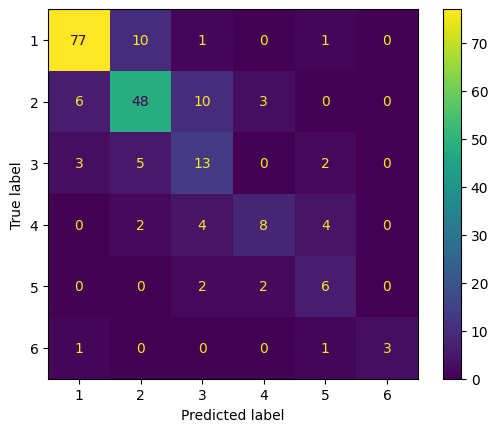

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
base_pred = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test)


In [49]:
print(classification_report(y_test,base_pred))

              precision    recall  f1-score   support

           1       0.89      0.87      0.88        89
           2       0.74      0.72      0.73        67
           3       0.43      0.57      0.49        23
           4       0.62      0.44      0.52        18
           5       0.43      0.60      0.50        10
           6       1.00      0.60      0.75         5

    accuracy                           0.73       212
   macro avg       0.68      0.63      0.64       212
weighted avg       0.75      0.73      0.74       212



In [28]:
# from sklearn.tree import plot_tree
# plt.figure(figsize=(20,12),dpi=100)
# plot_tree(model,filled=True,feature_names=X.columns);

In [51]:
def report_model(model):
    model_preds = model.predict(X_test)
    print(classification_report(y_test,model_preds))
    print('\n')
    plt.figure(figsize=(12,8),dpi=150)
    plot_tree(model,filled=True,feature_names=X.columns);

              precision    recall  f1-score   support

           1       0.70      0.82      0.76        89
           2       0.59      0.57      0.58        67
           3       0.20      0.39      0.27        23
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         5

    accuracy                           0.57       212
   macro avg       0.25      0.30      0.27       212
weighted avg       0.50      0.57      0.53       212





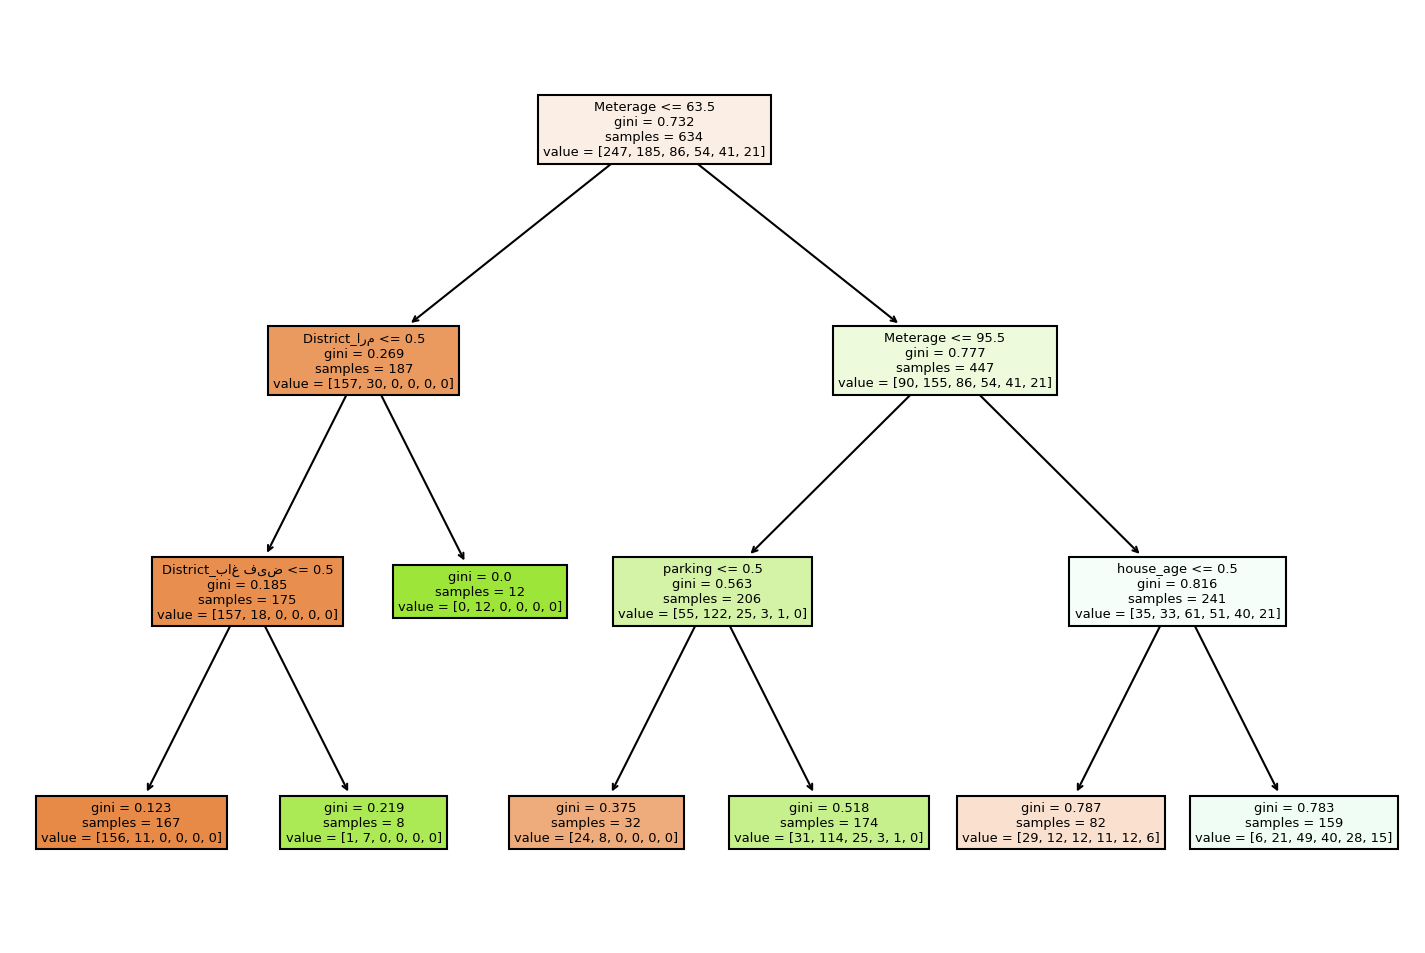

In [52]:
pruned_tree = DecisionTreeClassifier(max_depth=3)
pruned_tree.fit(X_train,y_train)
report_model(pruned_tree)

## KNN

In [189]:
def KNeighbors_def(metric_name, n_neighbors, X_train, y_train, X_test, y_test, list_metrics):
    # create an instance of the KNN model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric_name)

    # fit the model to the training data
    knn.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = knn.predict(X_test)

    # evaluate the model's performance
    list_metrics = All_metrics(y_test,y_pred, list_metrics=list_metrics, model_name='KNN-'+metric_name)
    return list_metrics

In [190]:
list_metrics = KNeighbors_def('euclidean', 6, X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'KNN-euclidean']

,Accuracy,Precision,Recall,F1
KNN-euclidean,0.576471,0.54501,0.576471,0.5501


In [191]:
list_metrics = KNeighbors_def('manhattan', 6, X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'KNN-manhattan']

,Accuracy,Precision,Recall,F1
KNN-manhattan,0.635294,0.607667,0.635294,0.612879


In [192]:
list_metrics = KNeighbors_def('minkowski', 6, X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'KNN-minkowski']

,Accuracy,Precision,Recall,F1
KNN-minkowski,0.576471,0.54501,0.576471,0.5501


# mohsen

Text(0.5, 1.0, 'Elbow Method for Choosing Reasonable K Values')

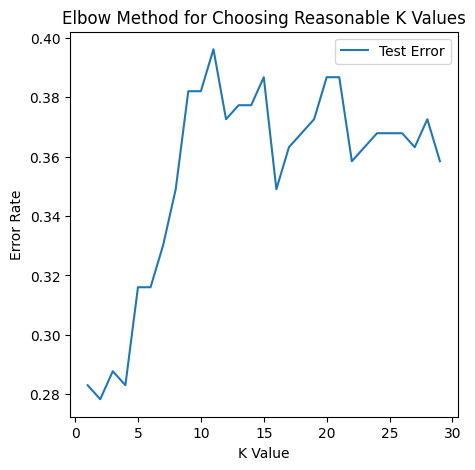

In [61]:
X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
from sklearn.neighbors import KNeighborsClassifier

test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)
    
plt.figure(figsize=(5,5))
plt.plot(range(1,30),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")
plt.title('Elbow Method for Choosing Reasonable K Values')

In [56]:
X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
operations = [('scaler',scaler),('knn',knn)]
from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)
from sklearn.model_selection import GridSearchCV
k_values = list(range(1,20))
param_grid = {'knn__n_neighbors': k_values}
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')
full_cv_classifier.fit(X_train,y_train)
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [57]:
scaler = StandardScaler()
knn14 = KNeighborsClassifier(n_neighbors=1)
operations = [('scaler',scaler),('knn14',knn14)]
pipe = Pipeline(operations)
pipe.fit(X_train,y_train)
pipe_pred = pipe.predict(X_test)
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           1       0.86      0.84      0.85        89
           2       0.68      0.67      0.68        67
           3       0.50      0.65      0.57        23
           4       0.70      0.39      0.50        18
           5       0.50      0.70      0.58        10
           6       0.60      0.60      0.60         5

    accuracy                           0.72       212
   macro avg       0.64      0.64      0.63       212
weighted avg       0.73      0.72      0.72       212



## Random Forest

In [193]:
def Random_Forest_def(n_estimators, X_train, y_train, X_test, y_test, list_metrics):
    # create an instance of the Random Forest model
    rf = RandomForestClassifier(n_estimators=n_estimators)

    # fit the model to the training data
    rf.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = rf.predict(X_test)

    # evaluate the model's performance
    list_metrics = All_metrics(y_test,y_pred, list_metrics=list_metrics, model_name='Random-Forest')
    return list_metrics

In [194]:
list_metrics = Random_Forest_def(100, X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'Random-Forest']

,Accuracy,Precision,Recall,F1
Random-Forest,0.764706,0.757152,0.764706,0.758067


# mohsen

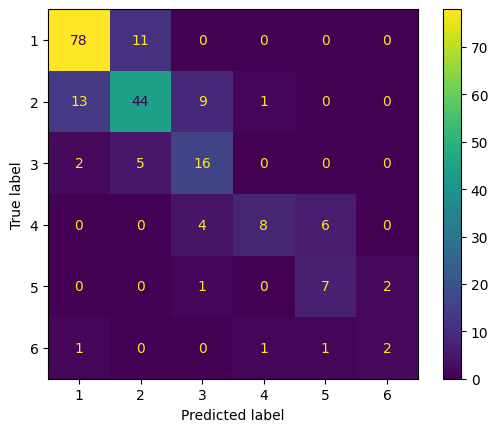

In [75]:
X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=128,max_features=3,random_state=101,bootstrap=True,oob_score=True)
model.fit(X_train,y_train)
preds = model.predict(X_test)
plot_confusion_matrix(model,X_test,y_test)

In [77]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           1       0.83      0.88      0.85        89
           2       0.73      0.66      0.69        67
           3       0.53      0.70      0.60        23
           4       0.80      0.44      0.57        18
           5       0.50      0.70      0.58        10
           6       0.50      0.40      0.44         5

    accuracy                           0.73       212
   macro avg       0.65      0.63      0.62       212
weighted avg       0.74      0.73      0.73       212



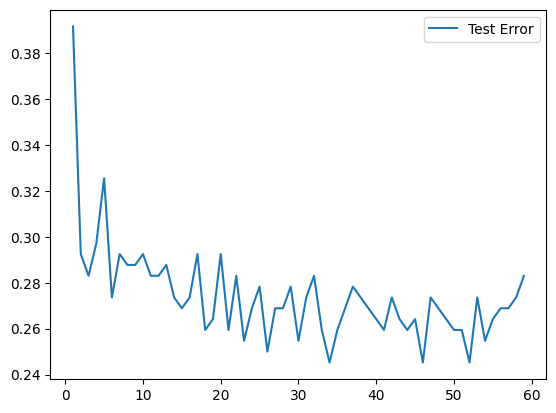

In [66]:
test_error = []

for n in range(1,60):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='auto')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
plt.plot(range(1,60),test_error,label='Test Error')
plt.legend()

In [78]:
from sklearn.model_selection import GridSearchCV
X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
n_estimators=[10,35,64,100,128]
max_features= [2,3,4]
bootstrap = [True,False]
oob_score = [True,False]
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'oob_score':oob_score}  # Note, oob_score only makes sense when bootstrap=True!
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)
grid.fit(X_train,y_train)
grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 64, 'oob_score': True}

In [79]:
predictions = grid.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.83      0.91      0.87        89
           2       0.77      0.64      0.70        67
           3       0.53      0.70      0.60        23
           4       0.80      0.44      0.57        18
           5       0.50      0.70      0.58        10
           6       0.50      0.40      0.44         5

    accuracy                           0.74       212
   macro avg       0.65      0.63      0.63       212
weighted avg       0.75      0.74      0.74       212



## Naïve Bayes

In [195]:
def Gaussian_NB_def(X_train, y_train, X_test, y_test, list_metrics):
    # create an instance of the GaussianNB model
    gnb = GaussianNB()

    # fit the model to the training data
    gnb.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = gnb.predict(X_test)

    # evaluate the model's performance
    list_metrics = All_metrics(y_test,y_pred, list_metrics=list_metrics, model_name='Guassian-Naive-Bayes')
    return list_metrics

In [196]:
list_metrics = Gaussian_NB_def(X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'Guassian-Naive-Bayes']

,Accuracy,Precision,Recall,F1
Guassian-Naive-Bayes,0.476471,0.586947,0.476471,0.506531


In [197]:
def Bernoulli_NB_def(X_train, y_train, X_test, y_test, list_metrics):
    # create an instance of the BernoulliNB model
    bnb = BernoulliNB()

    # fit the model to the training data
    bnb.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = bnb.predict(X_test)

    # evaluate the model's performance
    list_metrics = All_metrics(y_test,y_pred, list_metrics=list_metrics, model_name='Bernoulli-Naive-Bayes')
    return list_metrics

In [198]:
list_metrics = Bernoulli_NB_def(X_train, y_train, X_test, y_test, list_metrics)
list_metrics[list_metrics.index == 'Bernoulli-Naive-Bayes']

,Accuracy,Precision,Recall,F1
Bernoulli-Naive-Bayes,0.605882,0.589382,0.605882,0.570203


## All Metrics for Classification Methods

In [199]:
list_metrics

,Accuracy,Precision,Recall,F1
Logistic-Regression,0.529412,0.43726,0.529412,0.458045
SVM-linear,0.705882,0.71494,0.705882,0.703786
SVM-poly,0.4,0.16,0.4,0.228571
SVM-rbf,0.4,0.274153,0.4,0.325068
SVM-sigmoid,0.417647,0.250412,0.417647,0.307245
Decision-Tree-entropy,0.705882,0.699458,0.705882,0.701105
Decision-Tree-gini,0.735294,0.734035,0.735294,0.727147
KNN-euclidean,0.576471,0.54501,0.576471,0.5501
KNN-manhattan,0.635294,0.607667,0.635294,0.612879
KNN-minkowski,0.576471,0.54501,0.576471,0.5501


## Plot All Metrics for Classification Methods

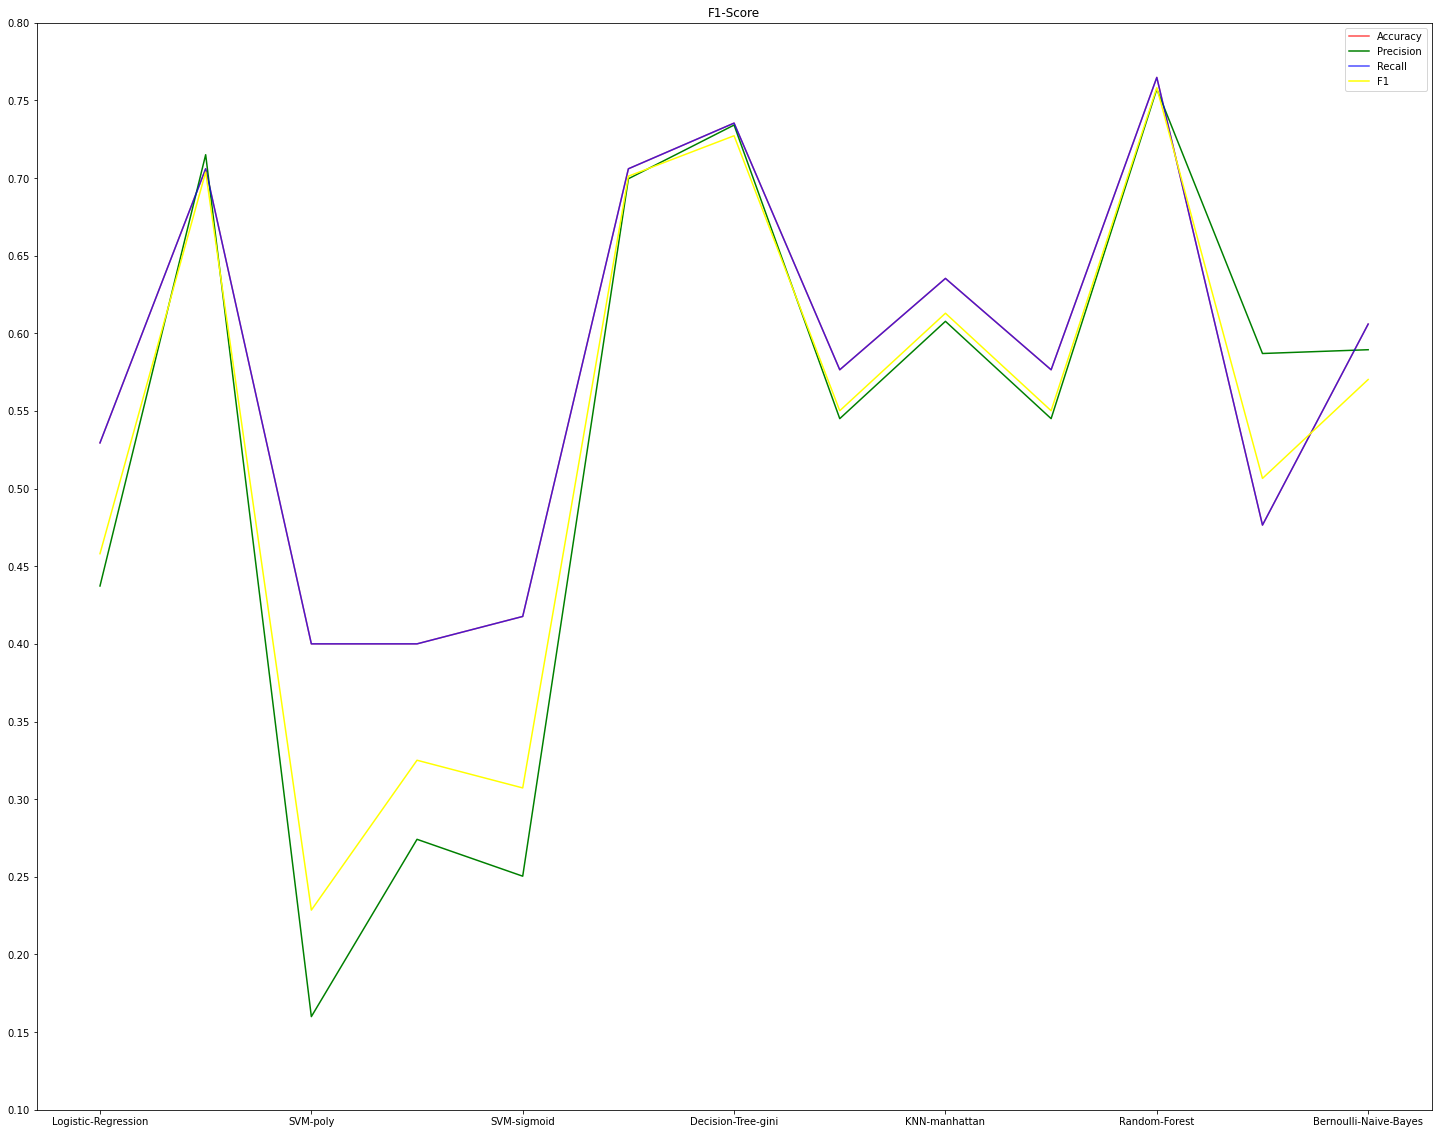

In [200]:
# plot line Accuracy and F1-Score and Precision and Recall for each model in a single plot 
plt.figure(figsize=(25, 20))
list_metrics['Accuracy'].plot(kind='line', title='Accuracy', color='red', alpha=0.7)
list_metrics['Precision'].plot(kind='line', title='Precision', color='green')
list_metrics['Recall'].plot(kind='line', title='Recall', color='blue', alpha=0.7)
list_metrics['F1'].plot(kind='line', title='F1-Score', color='yellow')
plt.yticks(np.arange(0.1, 0.85, 0.05))
plt.legend()
# plt save as a jpg file
plt.savefig('Accuracy_Precision_Recall_F1.jpg', dpi=300)
plt.show()

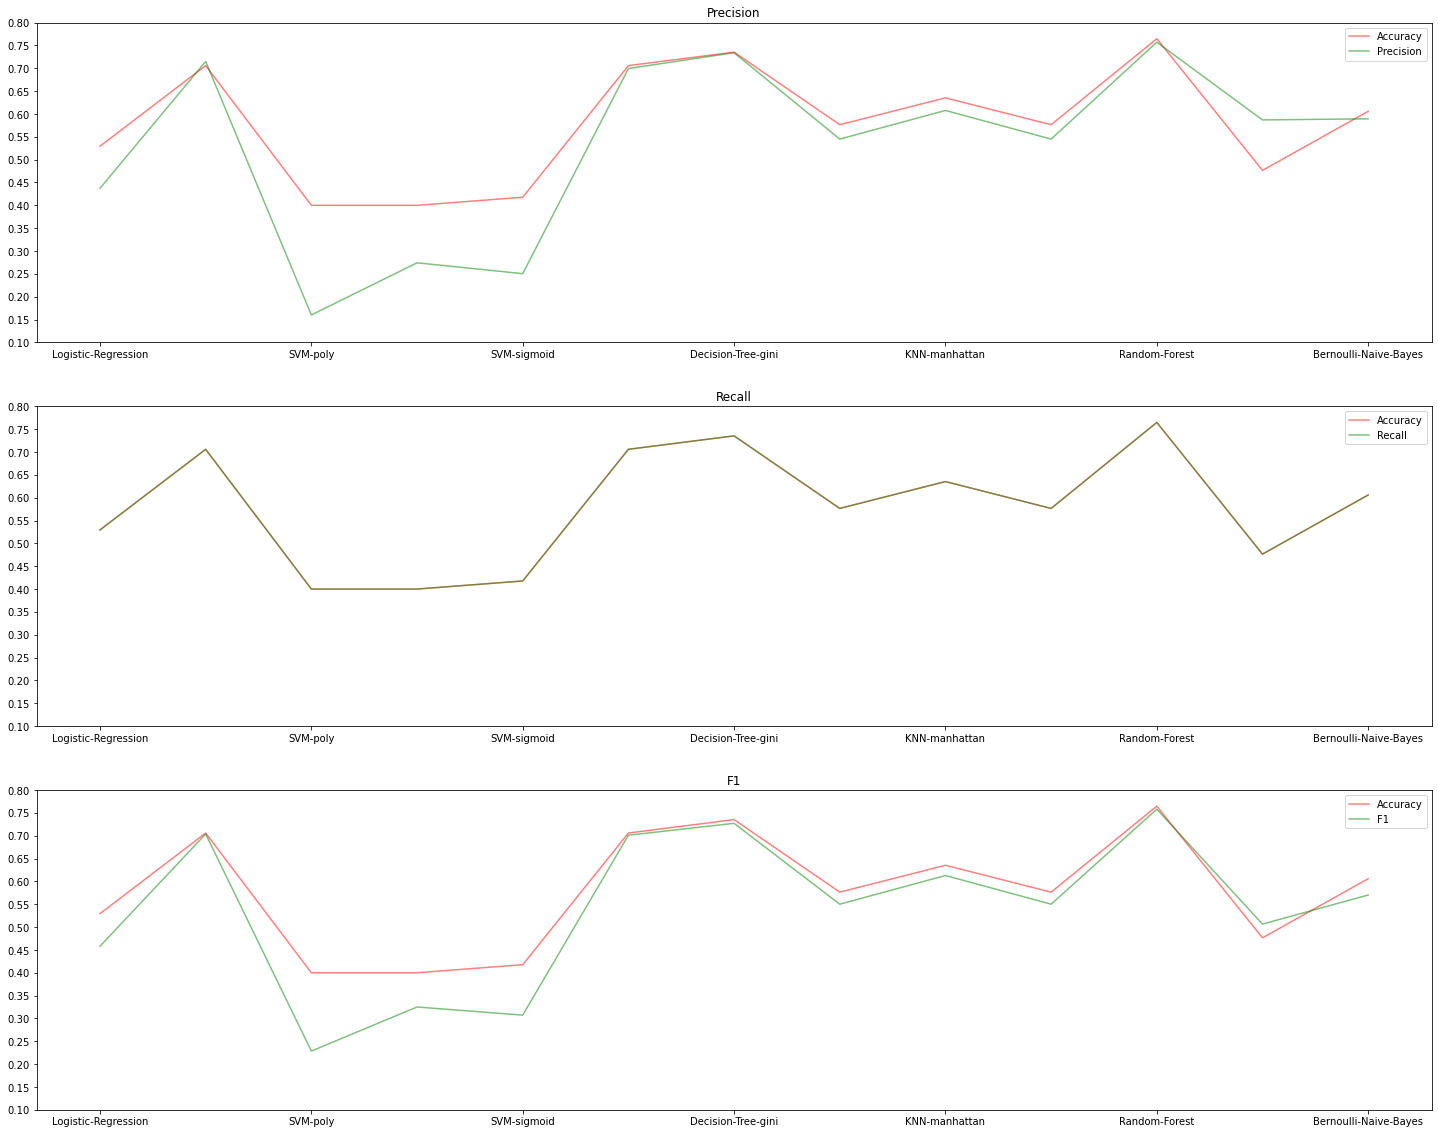

In [201]:
# plot line Accuracy and Precision for each model in a single plot
plt.figure(figsize=(25, 20))
plt.subplot(3, 1, 1)
list_metrics['Accuracy'].plot(kind='line', title='Accuracy', color='red', alpha=0.5)
list_metrics['Precision'].plot(kind='line', title='Precision', color='green', alpha=0.5)
plt.yticks(np.arange(0.1, 0.85, 0.05))
plt.legend()
plt.savefig('Accuracy_Precision.jpg', dpi=300)
plt.subplot(3, 1, 2)
list_metrics['Accuracy'].plot(kind='line', title='Accuracy', color='red', alpha=0.5)
list_metrics['Recall'].plot(kind='line', title='Recall', color='green', alpha=0.5)
plt.yticks(np.arange(0.1, 0.85, 0.05))
plt.legend()
plt.savefig('Accuracy_Recall.jpg', dpi=300)
plt.subplot(3, 1, 3)
list_metrics['Accuracy'].plot(kind='line', title='Accuracy', color='red', alpha=0.5)
list_metrics['F1'].plot(kind='line', title='F1', color='green', alpha=0.5)
plt.yticks(np.arange(0.1, 0.85, 0.05))
plt.legend()
plt.savefig('Accuracy_F1.jpg', dpi=300)
plt.show()

## Train Model with best effective features

In [202]:
# choose columns from df_classification_x which are maybe in df_rfr_x
df_clf_best_features = df_classification_x.loc[:, df_classification_x.columns.isin(df_rfr_x.columns)]
df_clf_best_features

,parking,Elevator,Meterage,room,house_age
0,1,1,120,2,0
1,0,0,35,0,21
2,1,1,117,2,1
3,1,1,87,2,10
4,1,1,130,3,0
...,...,...,...,...,...
841,1,1,128,3,13
842,1,1,93,2,16
843,1,1,85,2,11
844,1,1,138,3,0


In [203]:
X_train_best_features, X_test_best_features, y_train_best_features,y_test_best_features = train_test_split(df_clf_best_features,
 df_final.price_group, test_size=0.2, random_state=42,stratify=df_final.price_group)

In [204]:
list_metrics_best_features=pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])

In [205]:
list_metrics_best_features = Logistic_Regression_def(X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = SVM_def('linear', X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = SVM_def('poly', X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = SVM_def('rbf', X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = SVM_def('sigmoid', X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = Decision_Tree_def('entropy', X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = Decision_Tree_def('gini', X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = KNeighbors_def('euclidean', 6, X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = KNeighbors_def('manhattan', 6, X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = KNeighbors_def('minkowski', 6, X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = Random_Forest_def(100, X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = Gaussian_NB_def(X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features = Bernoulli_NB_def(X_train, y_train, X_test, y_test, list_metrics_best_features)
list_metrics_best_features

,Accuracy,Precision,Recall,F1
Logistic-Regression,0.529412,0.43726,0.529412,0.458045
SVM-linear,0.705882,0.71494,0.705882,0.703786
SVM-poly,0.4,0.16,0.4,0.228571
SVM-rbf,0.4,0.274153,0.4,0.325068
SVM-sigmoid,0.417647,0.250412,0.417647,0.307245
Decision-Tree-entropy,0.7,0.68943,0.7,0.692499
Decision-Tree-gini,0.723529,0.706897,0.723529,0.709788
KNN-euclidean,0.576471,0.54501,0.576471,0.5501
KNN-manhattan,0.635294,0.607667,0.635294,0.612879
KNN-minkowski,0.576471,0.54501,0.576471,0.5501


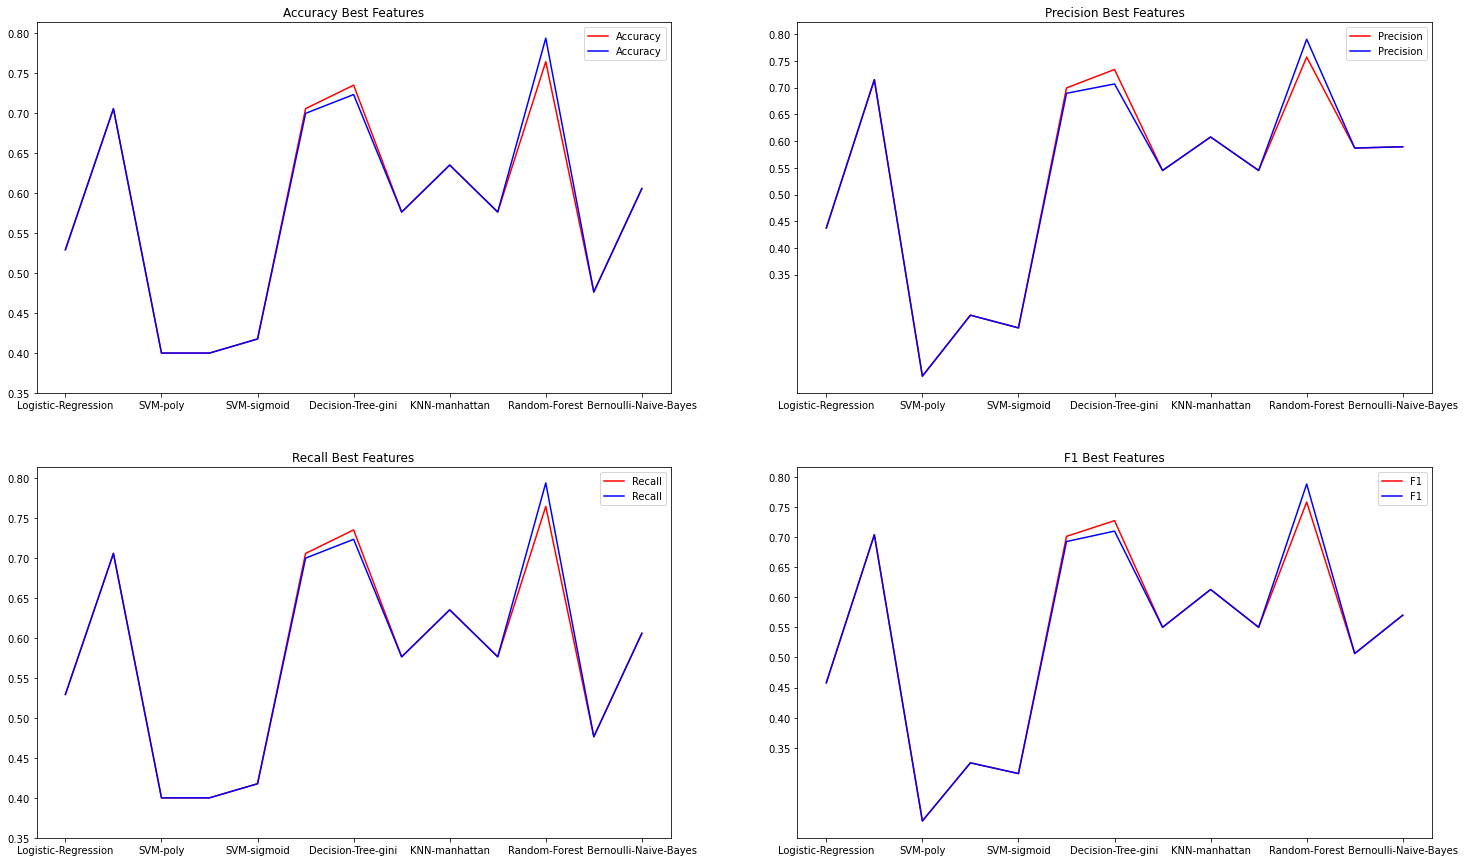

In [206]:
# plot line Accuracy for each model in a single plot 
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
list_metrics['Accuracy'].plot(kind='line', title='Accuracy All Features', color='red')
list_metrics_best_features['Accuracy'].plot(kind='line', title='Accuracy Best Features', color='blue')
plt.yticks(np.arange(0.35, 0.85, 0.05))
plt.legend()
plt.subplot(2, 2, 2)
list_metrics['Precision'].plot(kind='line', title='Precision All Features', color='red')
list_metrics_best_features['Precision'].plot(kind='line', title='Precision Best Features', color='blue')
plt.yticks(np.arange(0.35, 0.85, 0.05))
plt.legend()
plt.subplot(2, 2, 3)
list_metrics['Recall'].plot(kind='line', title='Recall All Features', color='red')
list_metrics_best_features['Recall'].plot(kind='line', title='Recall Best Features', color='blue')
plt.yticks(np.arange(0.35, 0.85, 0.05))
plt.legend()
plt.subplot(2, 2, 4)
list_metrics['F1'].plot(kind='line', title='F1 All Features', color='red')
list_metrics_best_features['F1'].plot(kind='line', title='F1 Best Features', color='blue')
plt.yticks(np.arange(0.35, 0.85, 0.05))
plt.legend()
plt.savefig('All_vs_Best.jpg', dpi=300)
plt.show()

## Plot Accuracy for Classification Methods

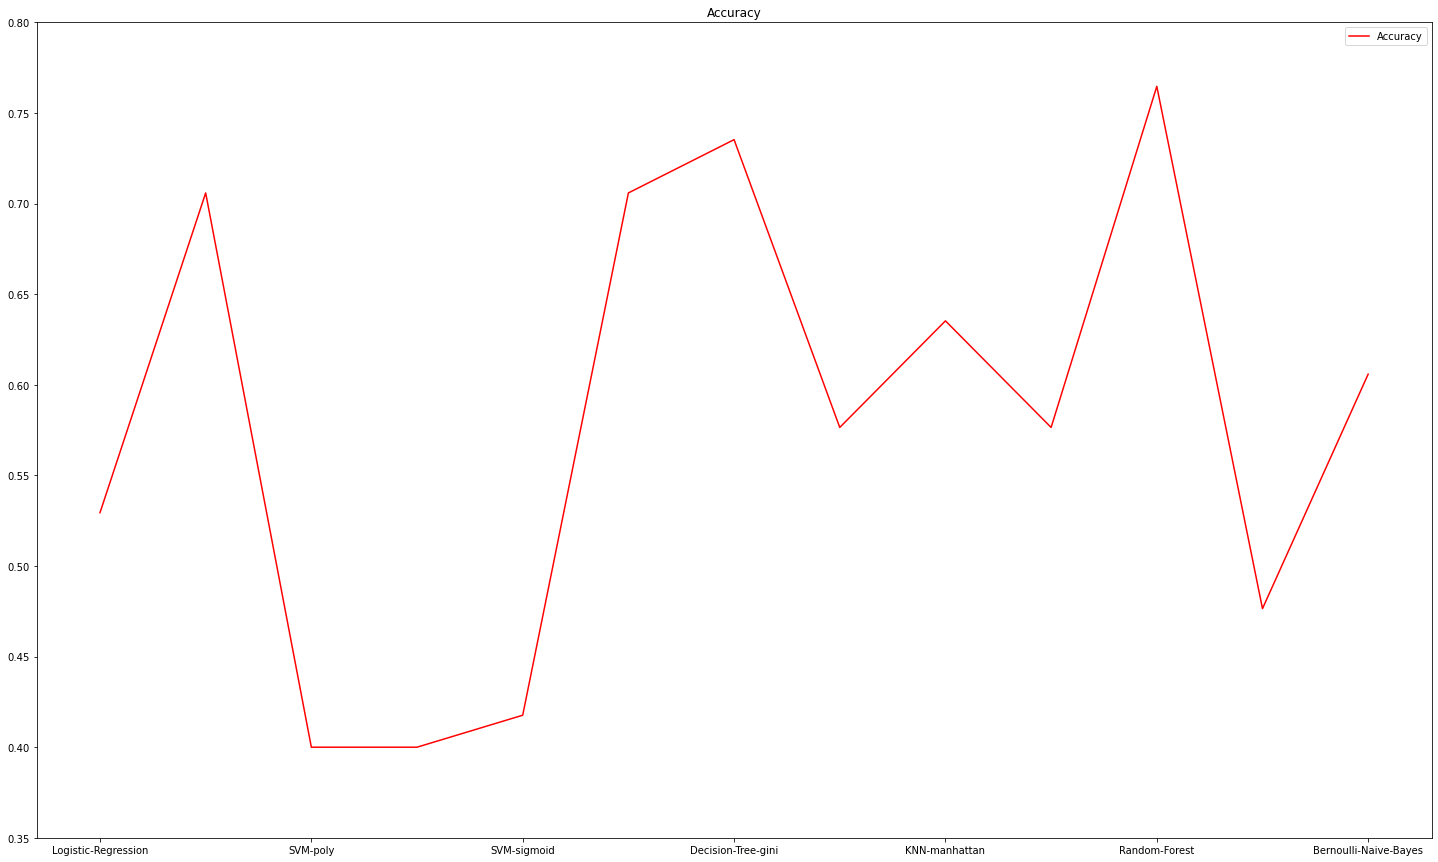

In [207]:
# plot line Accuracy for each model in a single plot 
plt.figure(figsize=(25, 15))
list_metrics['Accuracy'].plot(kind='line', title='Accuracy', color='red')
plt.yticks(np.arange(0.35, 0.85, 0.05))
plt.legend()
plt.savefig('Accuracy_for_all_model.jpg', dpi=300)
plt.show()

In [208]:
list_metrics

,Accuracy,Precision,Recall,F1
Logistic-Regression,0.529412,0.43726,0.529412,0.458045
SVM-linear,0.705882,0.71494,0.705882,0.703786
SVM-poly,0.4,0.16,0.4,0.228571
SVM-rbf,0.4,0.274153,0.4,0.325068
SVM-sigmoid,0.417647,0.250412,0.417647,0.307245
Decision-Tree-entropy,0.705882,0.699458,0.705882,0.701105
Decision-Tree-gini,0.735294,0.734035,0.735294,0.727147
KNN-euclidean,0.576471,0.54501,0.576471,0.5501
KNN-manhattan,0.635294,0.607667,0.635294,0.612879
KNN-minkowski,0.576471,0.54501,0.576471,0.5501


## Esemble Methods

In [216]:
list_metrics_new = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [217]:
# Create an instance of the Logistic Regression classifier
lr_clf = LogisticRegression(random_state=42)

# Create an instance of the SVM classifier with a linear kernel
svm_clf_linear = SVC(kernel='linear', random_state=42)

# Create an instance of the SVM classifier with a poly kernel
svm_clf_poly = SVC(kernel='poly', degree=3, random_state=42)

# Create an instance of the SVM classifier with a rbf kernel
svm_clf_rbf = SVC(kernel='rbf', gamma='scale', random_state=42)

# Create an instance of the SVM classifier with a rbf kernel
svm_clf_sigmoid = SVC(kernel='sigmoid', coef0=0, random_state=42)

# Create an instance of the Decision Tree classifier with a entropy criterion
dt_clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Create an instance of the Decision Tree classifier with a gini criterion
dt_clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42)

# Create an instance of the KNN classifier with an euclidean distance metric
knn_clf_euclidean = KNeighborsClassifier(n_neighbors=6, metric='euclidean')

# Create an instance of the KNN classifier with a manhattan distance metric
knn_clf_manhattan = KNeighborsClassifier(n_neighbors=6, metric='manhattan')

# Create an instance of the KNN classifier with a minkowski metric
knn_clf_minkowski = KNeighborsClassifier(n_neighbors=6, metric='minkowski', p=5)

# Create an instance of the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create an instance of the Guassian Naive Bayes classifier
gnb_clf = GaussianNB()

# Create an instance of the Bernoulli Naive Bayes classifier
bnb_clf = BernoulliNB()

#Create an instance of the BaggingClassifier for each classifier
lr_bag = BaggingClassifier(base_estimator=lr_clf, n_estimators=10, random_state=42)
svm_linear_bag = BaggingClassifier(base_estimator=svm_clf_linear, n_estimators=10, random_state=42)
svm_poly_bag = BaggingClassifier(base_estimator=svm_clf_poly, n_estimators=10, random_state=42)
svm_rbf_bag = BaggingClassifier(base_estimator=svm_clf_rbf, n_estimators=10, random_state=42)
svm_sigmoid_bag = BaggingClassifier(base_estimator=svm_clf_sigmoid, n_estimators=10, random_state=42)
dt_entropy_bag = BaggingClassifier(base_estimator=dt_clf_entropy, n_estimators=10, random_state=42)
dt_gini_bag = BaggingClassifier(base_estimator=dt_clf_gini, n_estimators=10, random_state=42)
knn_euclidean_bag = BaggingClassifier(base_estimator=knn_clf_euclidean, n_estimators=10, random_state=42)
knn_manhattan_bag = BaggingClassifier(base_estimator=knn_clf_manhattan, n_estimators=10, random_state=42)
knn_minkowski_bag = BaggingClassifier(base_estimator=knn_clf_minkowski, n_estimators=10, random_state=42)
rf_bag = BaggingClassifier(base_estimator=rf_clf, n_estimators=10, random_state=42)
gnb_bag = BaggingClassifier(base_estimator=gnb_clf, n_estimators=10, random_state=42)
bnb_bag = BaggingClassifier(base_estimator=bnb_clf, n_estimators=10, random_state=42)

# Fit the classifiers to the training data
lr_bag.fit(X_train, y_train)
svm_linear_bag.fit(X_train, y_train)
svm_poly_bag.fit(X_train, y_train)
svm_rbf_bag.fit(X_train, y_train)
svm_sigmoid_bag.fit(X_train, y_train)
dt_entropy_bag.fit(X_train, y_train)
dt_gini_bag.fit(X_train, y_train)
knn_euclidean_bag.fit(X_train, y_train)
knn_manhattan_bag.fit(X_train, y_train)
knn_minkowski_bag.fit(X_train, y_train)
rf_bag.fit(X_train, y_train)
gnb_bag.fit(X_train, y_train)
bnb_bag.fit(X_train, y_train)

# Make predictions on the test data
lr_pred = lr_bag.predict(X_test)
svm_linear_pred = svm_linear_bag.predict(X_test)
svm_poly_pred = svm_poly_bag.predict(X_test)
svm_rbf_pred = svm_rbf_bag.predict(X_test)
svm_sigmoid_pred = svm_sigmoid_bag.predict(X_test)
dt_entropy_pred = dt_entropy_bag.predict(X_test)
dt_gini_pred = dt_gini_bag.predict(X_test)
knn_euclidean_pred = knn_euclidean_bag.predict(X_test)
knn_manhattan_pred = knn_manhattan_bag.predict(X_test)
knn_minkowski_pred = knn_minkowski_bag.predict(X_test)
rf_pred = rf_bag.predict(X_test)
gnb_pred = gnb_bag.predict(X_test)
bnb_pred = bnb_bag.predict(X_test)

# evaluate the model's performance
list_metrics_new = All_metrics(y_test,lr_pred, list_metrics_new, model_name='Bagging-Logistic-Regression-Classifier')
list_metrics_new = All_metrics(y_test,svm_linear_pred, list_metrics_new, model_name='Bagging-SVM-Linear-Classifier')
list_metrics_new = All_metrics(y_test,svm_poly_pred, list_metrics_new, model_name='Bagging-SVM-Poly-Classifier')
list_metrics_new = All_metrics(y_test,svm_rbf_pred, list_metrics_new, model_name='Bagging-SVM-RBF-Classifier')
list_metrics_new = All_metrics(y_test,svm_sigmoid_pred, list_metrics_new, model_name='Bagging-SVM-Sigmoid-Classifier')
list_metrics_new = All_metrics(y_test,dt_entropy_pred, list_metrics_new, model_name='Bagging-Decision-Tree-Entropy-Classifier')
list_metrics_new = All_metrics(y_test,dt_gini_pred, list_metrics_new, model_name='Bagging-Decision-Tree-Gini-Classifier')
list_metrics_new = All_metrics(y_test,knn_euclidean_pred, list_metrics_new, model_name='Bagging-KNN-Euclidean-Classifier')
list_metrics_new = All_metrics(y_test,knn_manhattan_pred, list_metrics_new, model_name='Bagging-KNN-Manhattan-Classifier')
list_metrics_new = All_metrics(y_test,knn_minkowski_pred, list_metrics_new, model_name='Bagging-KNN-Minkowski-Classifier')
list_metrics_new = All_metrics(y_test,rf_pred, list_metrics_new, model_name='Bagging-Random-Forest-Classifier')
list_metrics_new = All_metrics(y_test,gnb_pred, list_metrics_new, model_name='Bagging-Gaussian-Naive-Bayes-Classifier')
list_metrics_new = All_metrics(y_test,bnb_pred, list_metrics_new, model_name='Bagging-Bernoulli-Naive-Bayes-Classifier')

In [218]:
list_metrics_new

,Accuracy,Precision,Recall,F1
Bagging-Logistic-Regression-Classifier,0.529412,0.420155,0.529412,0.461314
Bagging-SVM-Linear-Classifier,0.723529,0.719444,0.723529,0.717722
Bagging-SVM-Poly-Classifier,0.4,0.16,0.4,0.228571
Bagging-SVM-RBF-Classifier,0.4,0.274992,0.4,0.325598
Bagging-SVM-Sigmoid-Classifier,0.417647,0.251575,0.417647,0.307725
Bagging-Decision-Tree-Entropy-Classifier,0.752941,0.747849,0.752941,0.744819
Bagging-Decision-Tree-Gini-Classifier,0.747059,0.736286,0.747059,0.737997
Bagging-KNN-Euclidean-Classifier,0.6,0.587518,0.6,0.589634
Bagging-KNN-Manhattan-Classifier,0.629412,0.608396,0.629412,0.61356
Bagging-KNN-Minkowski-Classifier,0.6,0.586251,0.6,0.587472


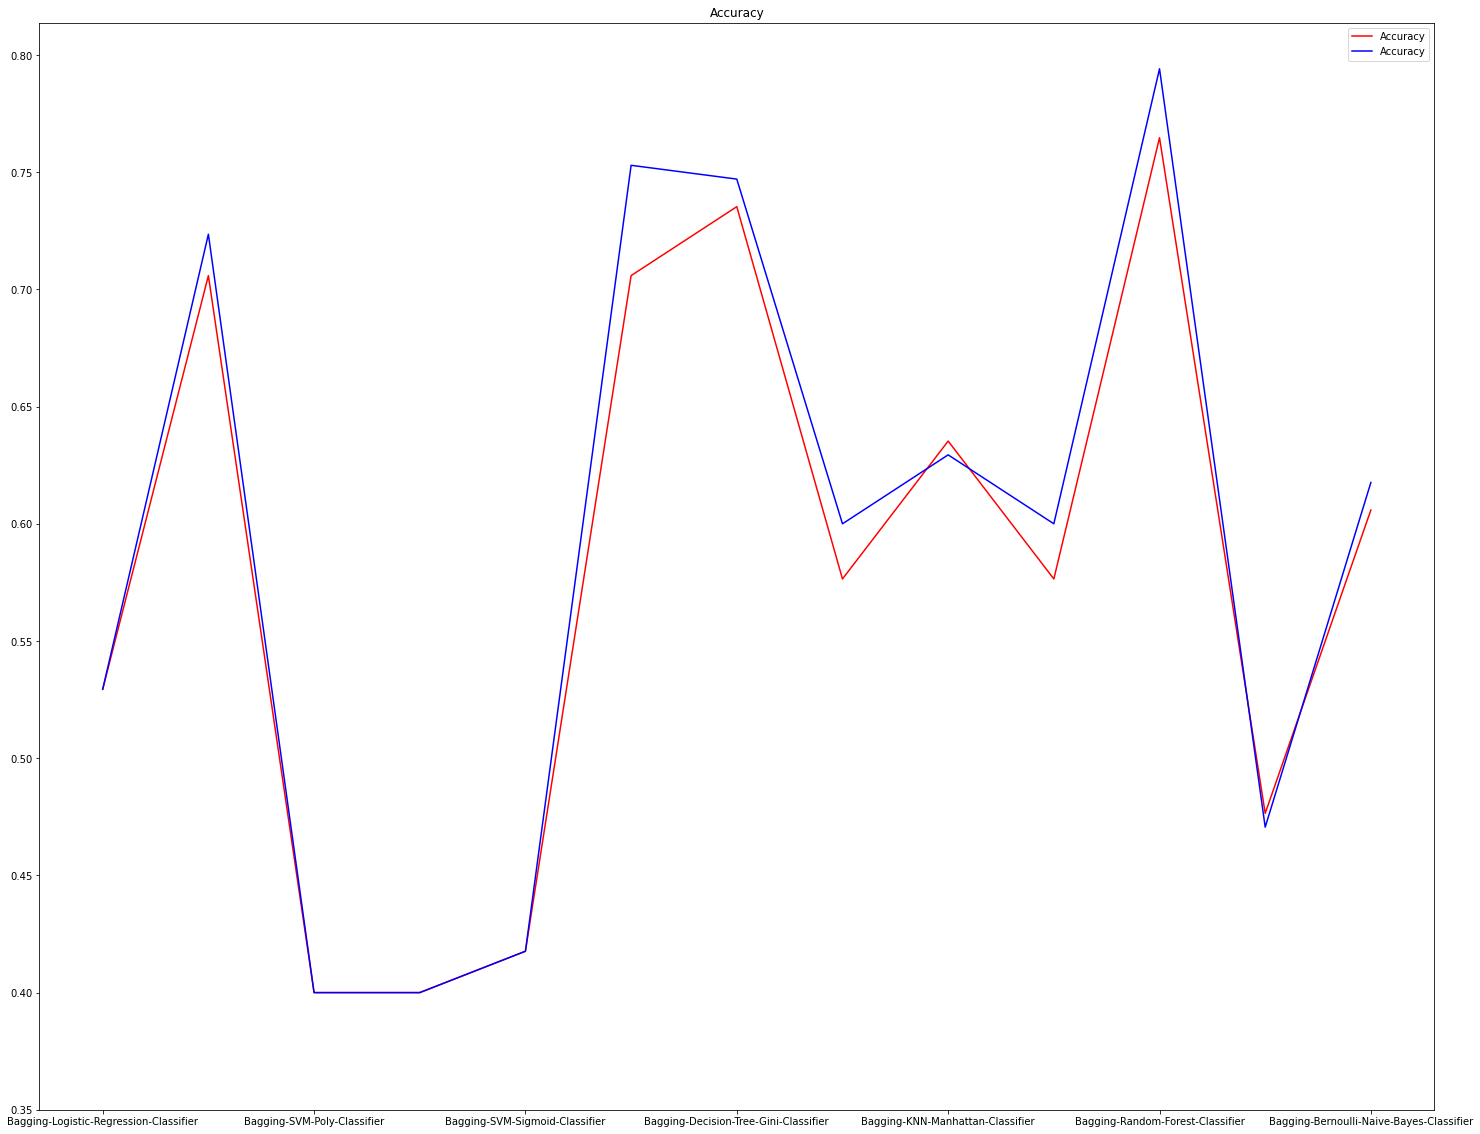

In [219]:
# plot line Accuracy and F1-Score and Precision and Recall for each model in a single plot 
plt.figure(figsize=(25, 20))
list_metrics['Accuracy'].plot(kind='line', title='Accuracy', color='red')
list_metrics_new['Accuracy'].plot(kind='line', title='Accuracy', color='blue')
plt.yticks(np.arange(0.35, 0.85, 0.05))
plt.legend()
# plt save as a jpg file
plt.savefig('New_Algorithm_Accuracy.jpg', dpi=300)
plt.show()

## Gradient Boosting Machine (GBM)

# mohsen

In [100]:
X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=101)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators":[1,5,10,20,40,100],'max_depth':[3,4,5,6,7]}
gb_model = GradientBoostingClassifier()
grid = GridSearchCV(gb_model,param_grid)
grid.fit(X_train,y_train)
grid.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [101]:
predictions = grid.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.85      0.86      0.86       122
           2       0.72      0.67      0.69        91
           3       0.43      0.53      0.47        38
           4       0.53      0.45      0.49        22
           5       0.59      0.56      0.57        18
           6       0.33      0.33      0.33         6

    accuracy                           0.70       297
   macro avg       0.57      0.57      0.57       297
weighted avg       0.71      0.70      0.70       297



In [116]:
X = df_final.drop('price_group',axis=1)
y = df_final['price_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb_model = GradientBoostingClassifier(max_depth=3,n_estimators=100)

gb_model.fit(X_train,y_train)

GradientBoostingClassifier()

In [117]:
predictions = grid.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.87      0.88      0.88       141
           2       0.75      0.70      0.72       101
           3       0.51      0.61      0.55        46
           4       0.59      0.52      0.55        25
           5       0.63      0.60      0.62        20
           6       0.33      0.33      0.33         6

    accuracy                           0.74       339
   macro avg       0.61      0.61      0.61       339
weighted avg       0.74      0.74      0.74       339



In [237]:
# Create an instance of the GBM classifier
gbm = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)

# Fit the classifier to the training data
gbm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gbm.predict(X_test)

# Evaluate the performance of the classifier
list_metrics_new = All_metrics(y_test,y_pred, list_metrics_new, model_name='Gradient-Boosting-Classifier')
# all dataframe if index is equal to 'Gradient-Boosting-Classifier' or 'Bagging-Random-Forest-Classifier'
two_model_new = list_metrics_new.loc[['Gradient-Boosting-Classifier', 'Bagging-Random-Forest-Classifier']]
two_model_new

,Accuracy,Precision,Recall,F1
Gradient-Boosting-Classifier,0.770588,0.76923,0.770588,0.764812
Bagging-Random-Forest-Classifier,0.794118,0.791658,0.794118,0.789233


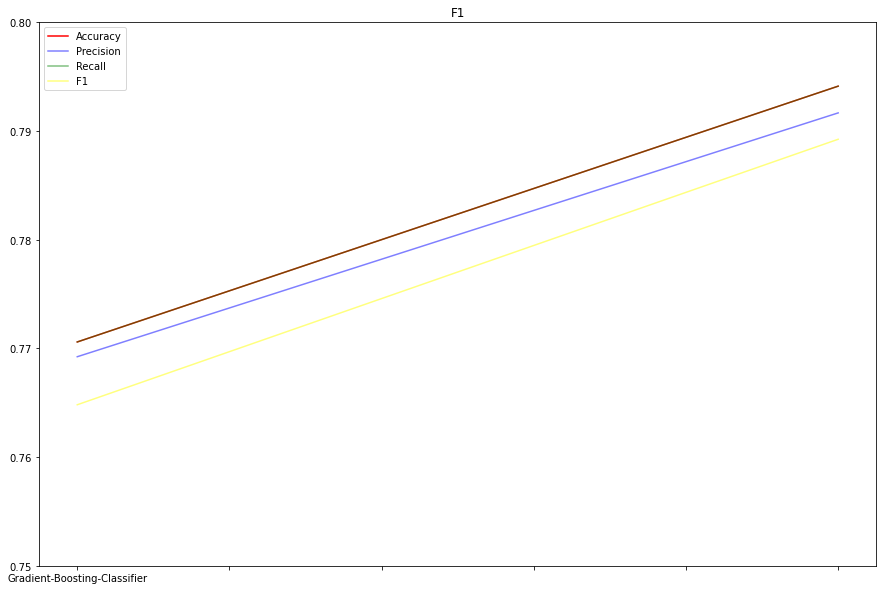

In [240]:
# plot line Accuracy and F1-Score and Precision and Recall for each model in a single plot 
plt.figure(figsize=(15, 10))
two_model_new['Accuracy'].plot(kind='line', title='Accuracy', color='red')
two_model_new['Precision'].plot(kind='line', title='Precision', color='blue', alpha=0.5)
two_model_new['Recall'].plot(kind='line', title='Recall', color='green', alpha=0.5)
two_model_new['F1'].plot(kind='line', title='F1', color='yellow', alpha=0.5)
plt.yticks(np.arange(0.75, 0.80, 0.01))
plt.legend()
# plt save as a jpg file
plt.savefig('two_new_model.jpg', dpi=300)
plt.show()